# Logistic Regression and Feature Exploration - In Detail

## Goal: To evaulate features quickly and efficiently to know which ones are most important for a ML model. 

### Examining the Relationships Between Features and the Response Variable

We can do this by using a correlation plot.

In [1]:
#Setup
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
import seaborn as sns #a fancy plotting package
mpl.rcParams['figure.dpi'] = 400 #high res figures
df = pd.read_csv('/home/joseph/python_projects/Chapter_1_cleaned_data.csv')

In [2]:
features_response = df.columns.tolist() 
features_response[:5]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [3]:
features_response[-5:]

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

We are not using the SEX variable due to ethical concerns. And from past work, we learned that PAY_2...PAY_6 is incorrect and should be ignored. Also, we are not examining the OHE we made from the EDUCATION variable since that info is alrady in the original feature in some form. ID is an identifier and it makes no sense to use it as a feature. 

Let's exclude the columns that are neither features nor response.

In [4]:
items_to_remove = ['ID', 'SEX','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','EDUCATION_CAT',\
'graduate school', 'high school', 'none','others', 'university'] #removing columns that aren't features or responses

To have a list of column names that only consist of features and responses,we must remove the contents of *items_to_remove* from *features_response*. We shall use a list comprehension to do this.

In [5]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### Pearson Correlation

Now, we can make a correlation plot. Underlying it is a correlation matrix which is made using the *.corr()* method.

In [6]:
corr = df[features_response].corr()
corr.iloc[0:5,0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<AxesSubplot:>

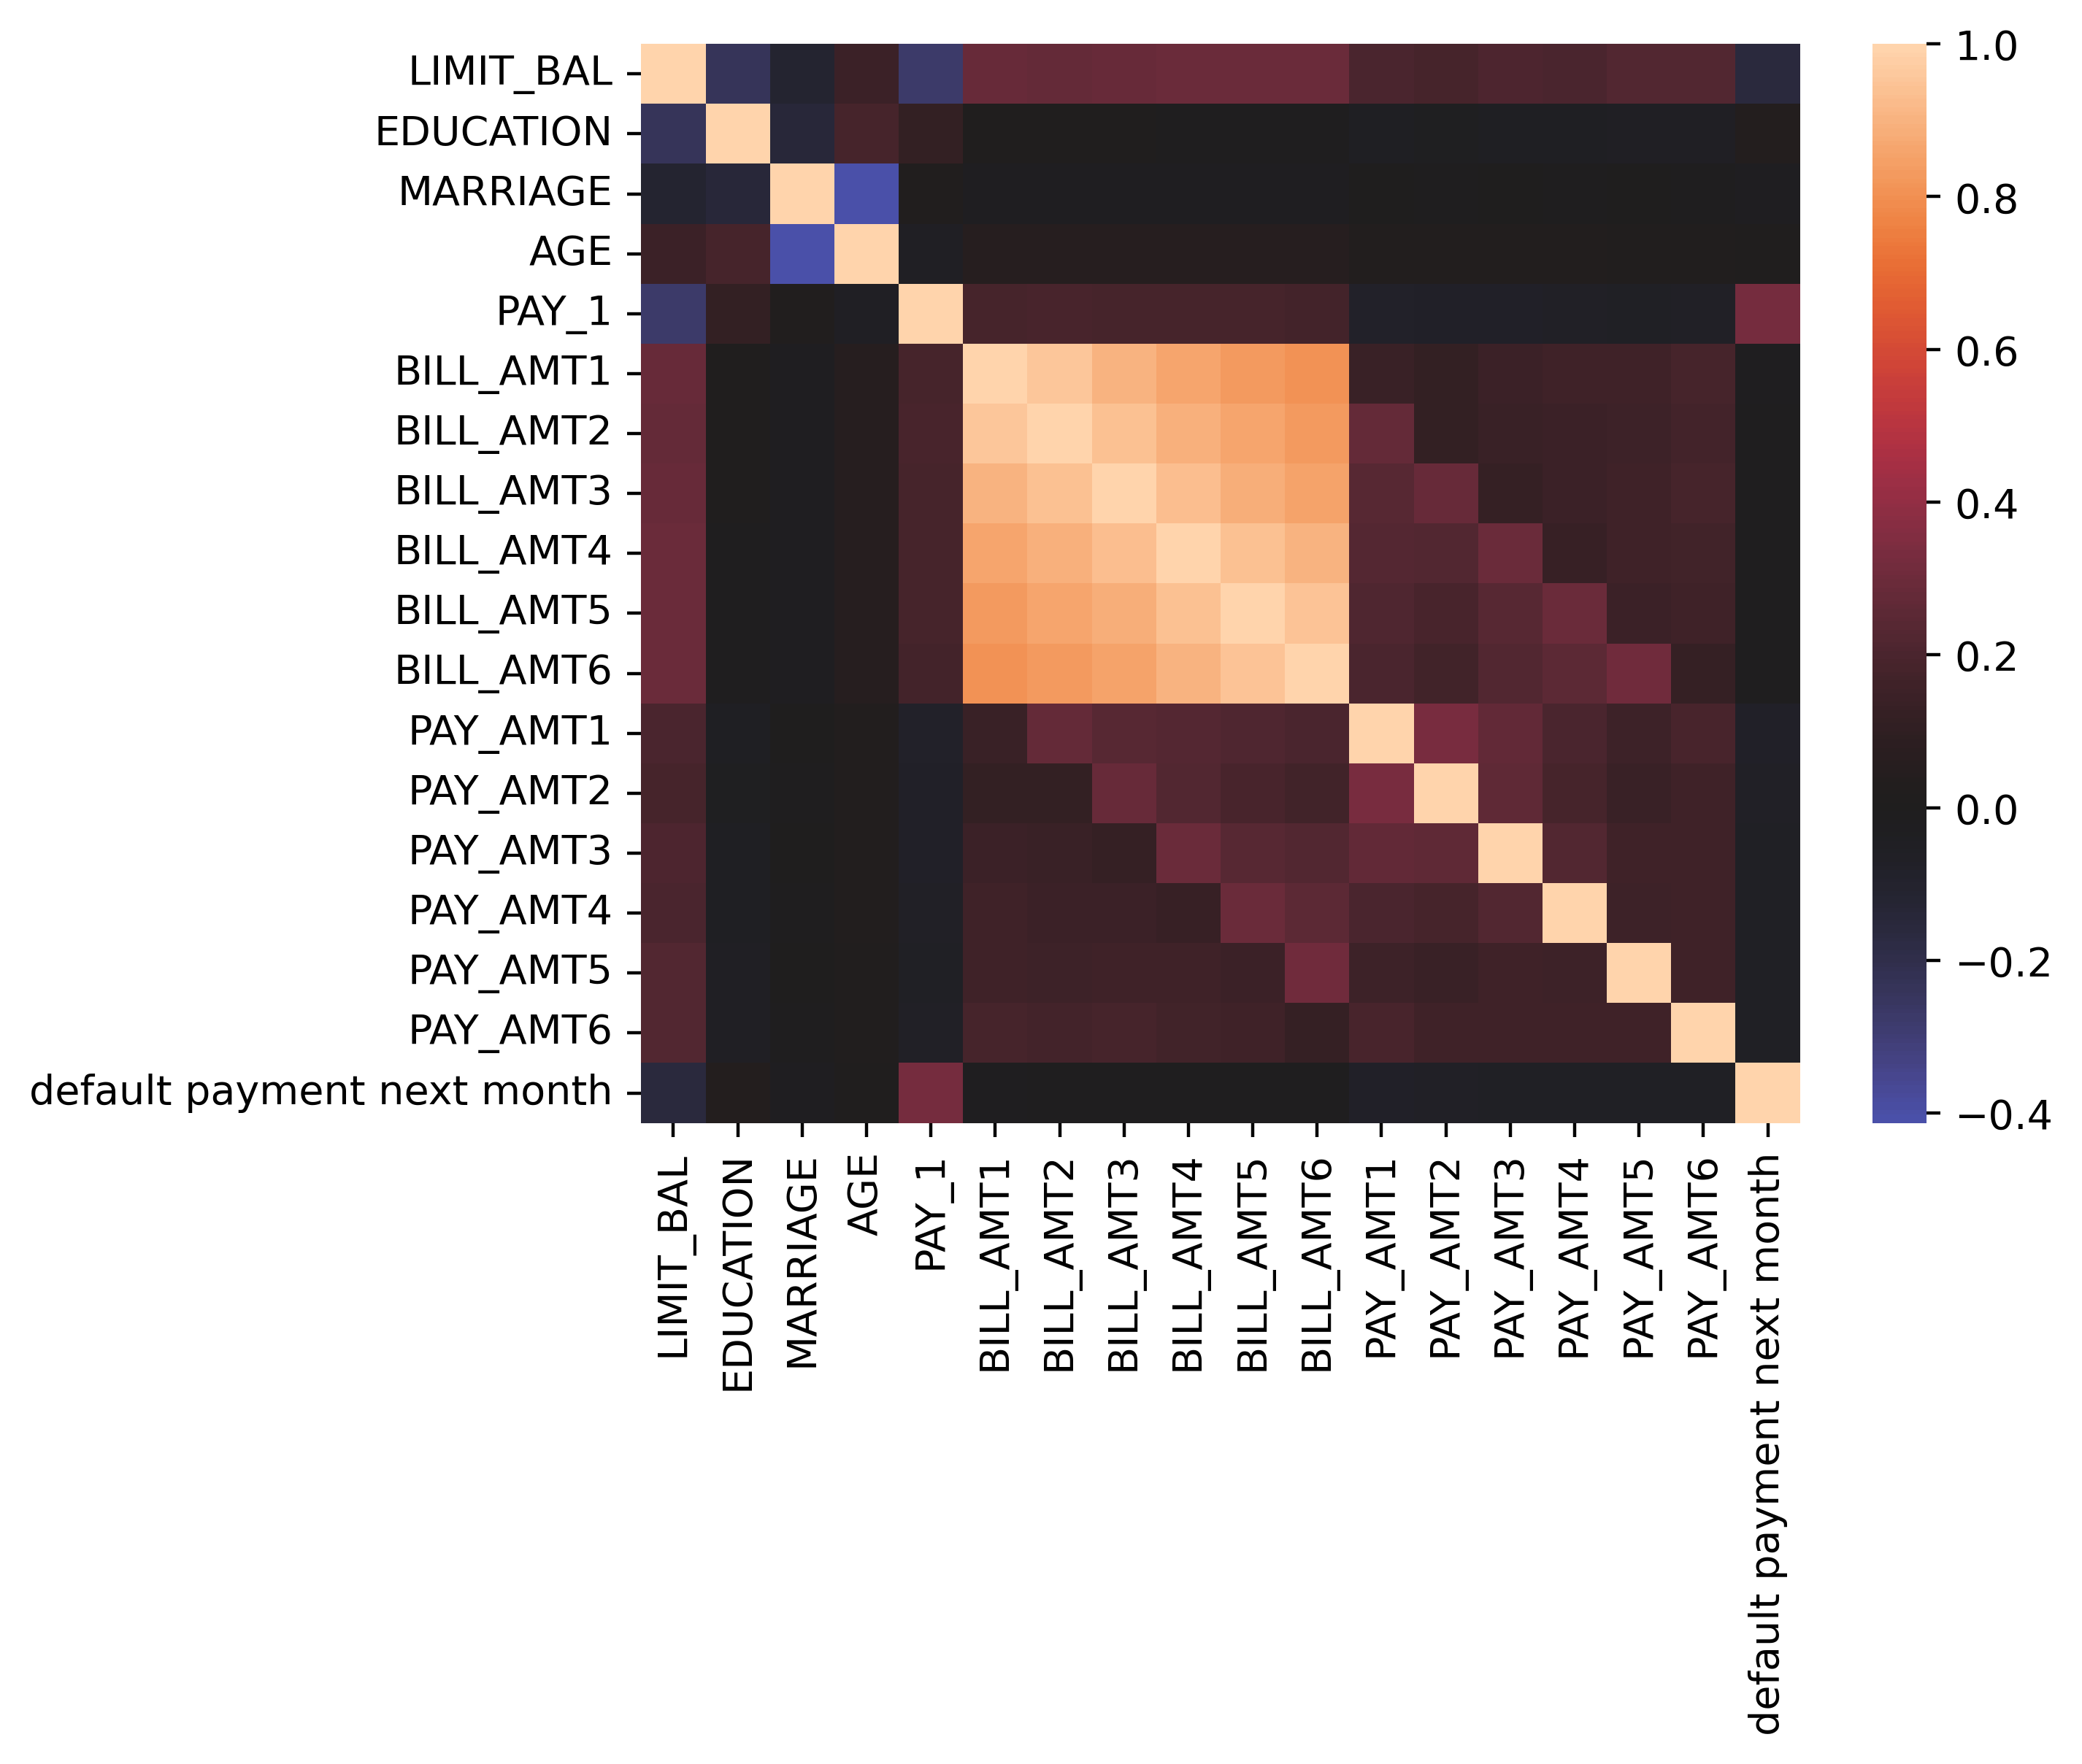

In [7]:
#Correlation plot
sns.heatmap(corr,
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
center=0)

Based on the heatmap above, we should use the PAY_1 feature since it seems to be the most strongly correlated feature to the response variable. We can also consider LIMIT_BAL, which is negatively correlated.

### F-Test

In [8]:
#Prepare for ANOVA F-test
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


In [9]:
from sklearn.feature_selection import f_classif
[f_stat, f_p_value] = f_classif(X, y) #Feed in features and response

In [10]:
f_test_df = pd.DataFrame({'Feature':features_response[:-1],'F statistic':f_stat,'p value':f_p_value})
f_test_df.sort_values('p value') #Sorted F-test dataframe

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


This confirms that PAY_1 and LIMIT_BAL are the features we must consider, since they have the lowest p-values. Measures such as the F-test help us perform univariate feature selection, which is especially helpful when you have a very large number of features and want to find out which ones are useful. To select the top 20% of features according to the F-test, we can use the SelectPercentile class or the SelectKBest (where k is any number you specify).

In [11]:
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(f_classif, percentile=20) #Top 20% of features from F-Test

In [12]:
selector.fit(X,y)

SelectPercentile(percentile=20)

In [13]:
best_feature_ix = selector.get_support() #Gives you the column indices of the feature array selected
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [14]:
features = features_response[:-1] #Obtain feature names

best_features = [features[counter]
                 for counter in range(len(features))
                 if best_feature_ix[counter]]
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

### Hypotheses and Next Steps
According to our univariate feature exploration PAY_1 is the feature with the strongest association with the response variable. To reiterate, for PAY_1, -2 means no account usage, -1 means balance paid in full, and 0 means that at least the minimum payment was made. Positive integer values indicate a delay in the payment by that many months.

In [15]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate #Create a baseline

0.2217971797179718

In [16]:
group_by_pay_mean_y = df.groupby('PAY_1').agg({'default payment next month':np.mean})
group_by_pay_mean_y #Compares PAY_1 to baseline

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


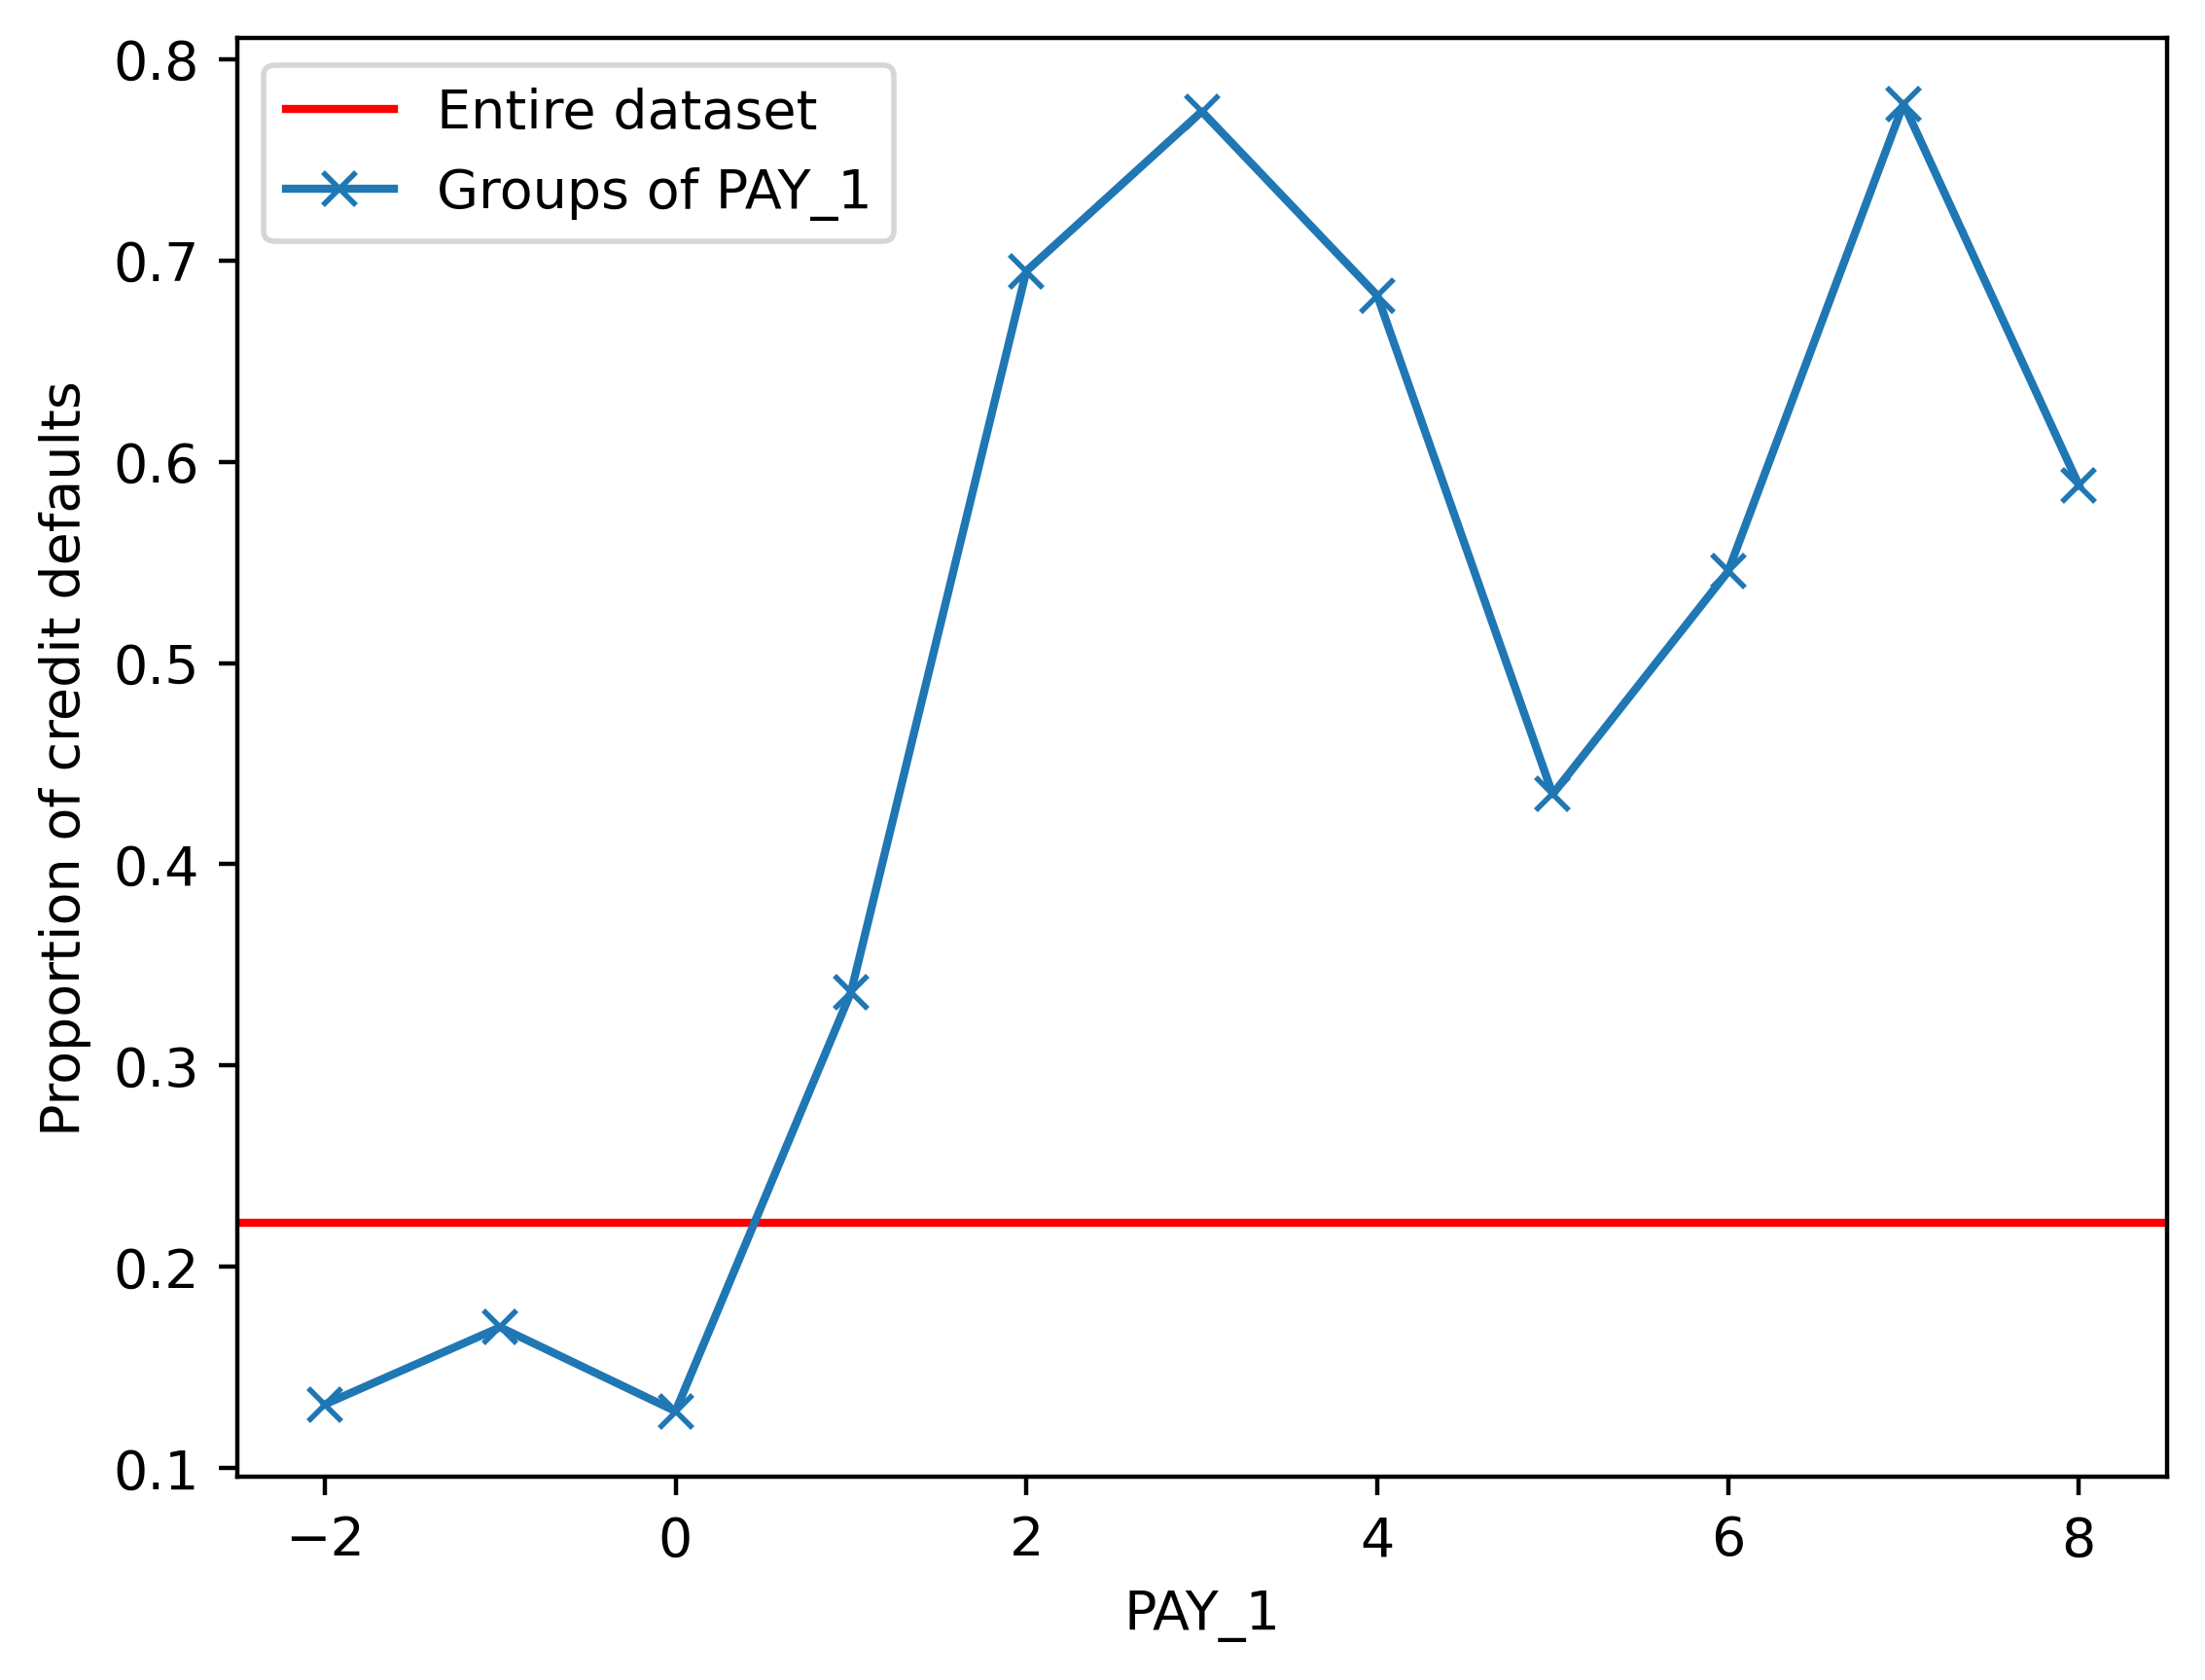

In [17]:
#Plot trend
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

In [18]:
#Take a look at LIMIT_BAL, the second strongest feature.
pos_mask = y == 1
neg_mask = y == 0 #Logical masks for histograms

Text(0.5, 1.0, 'Credit limits by response variable')

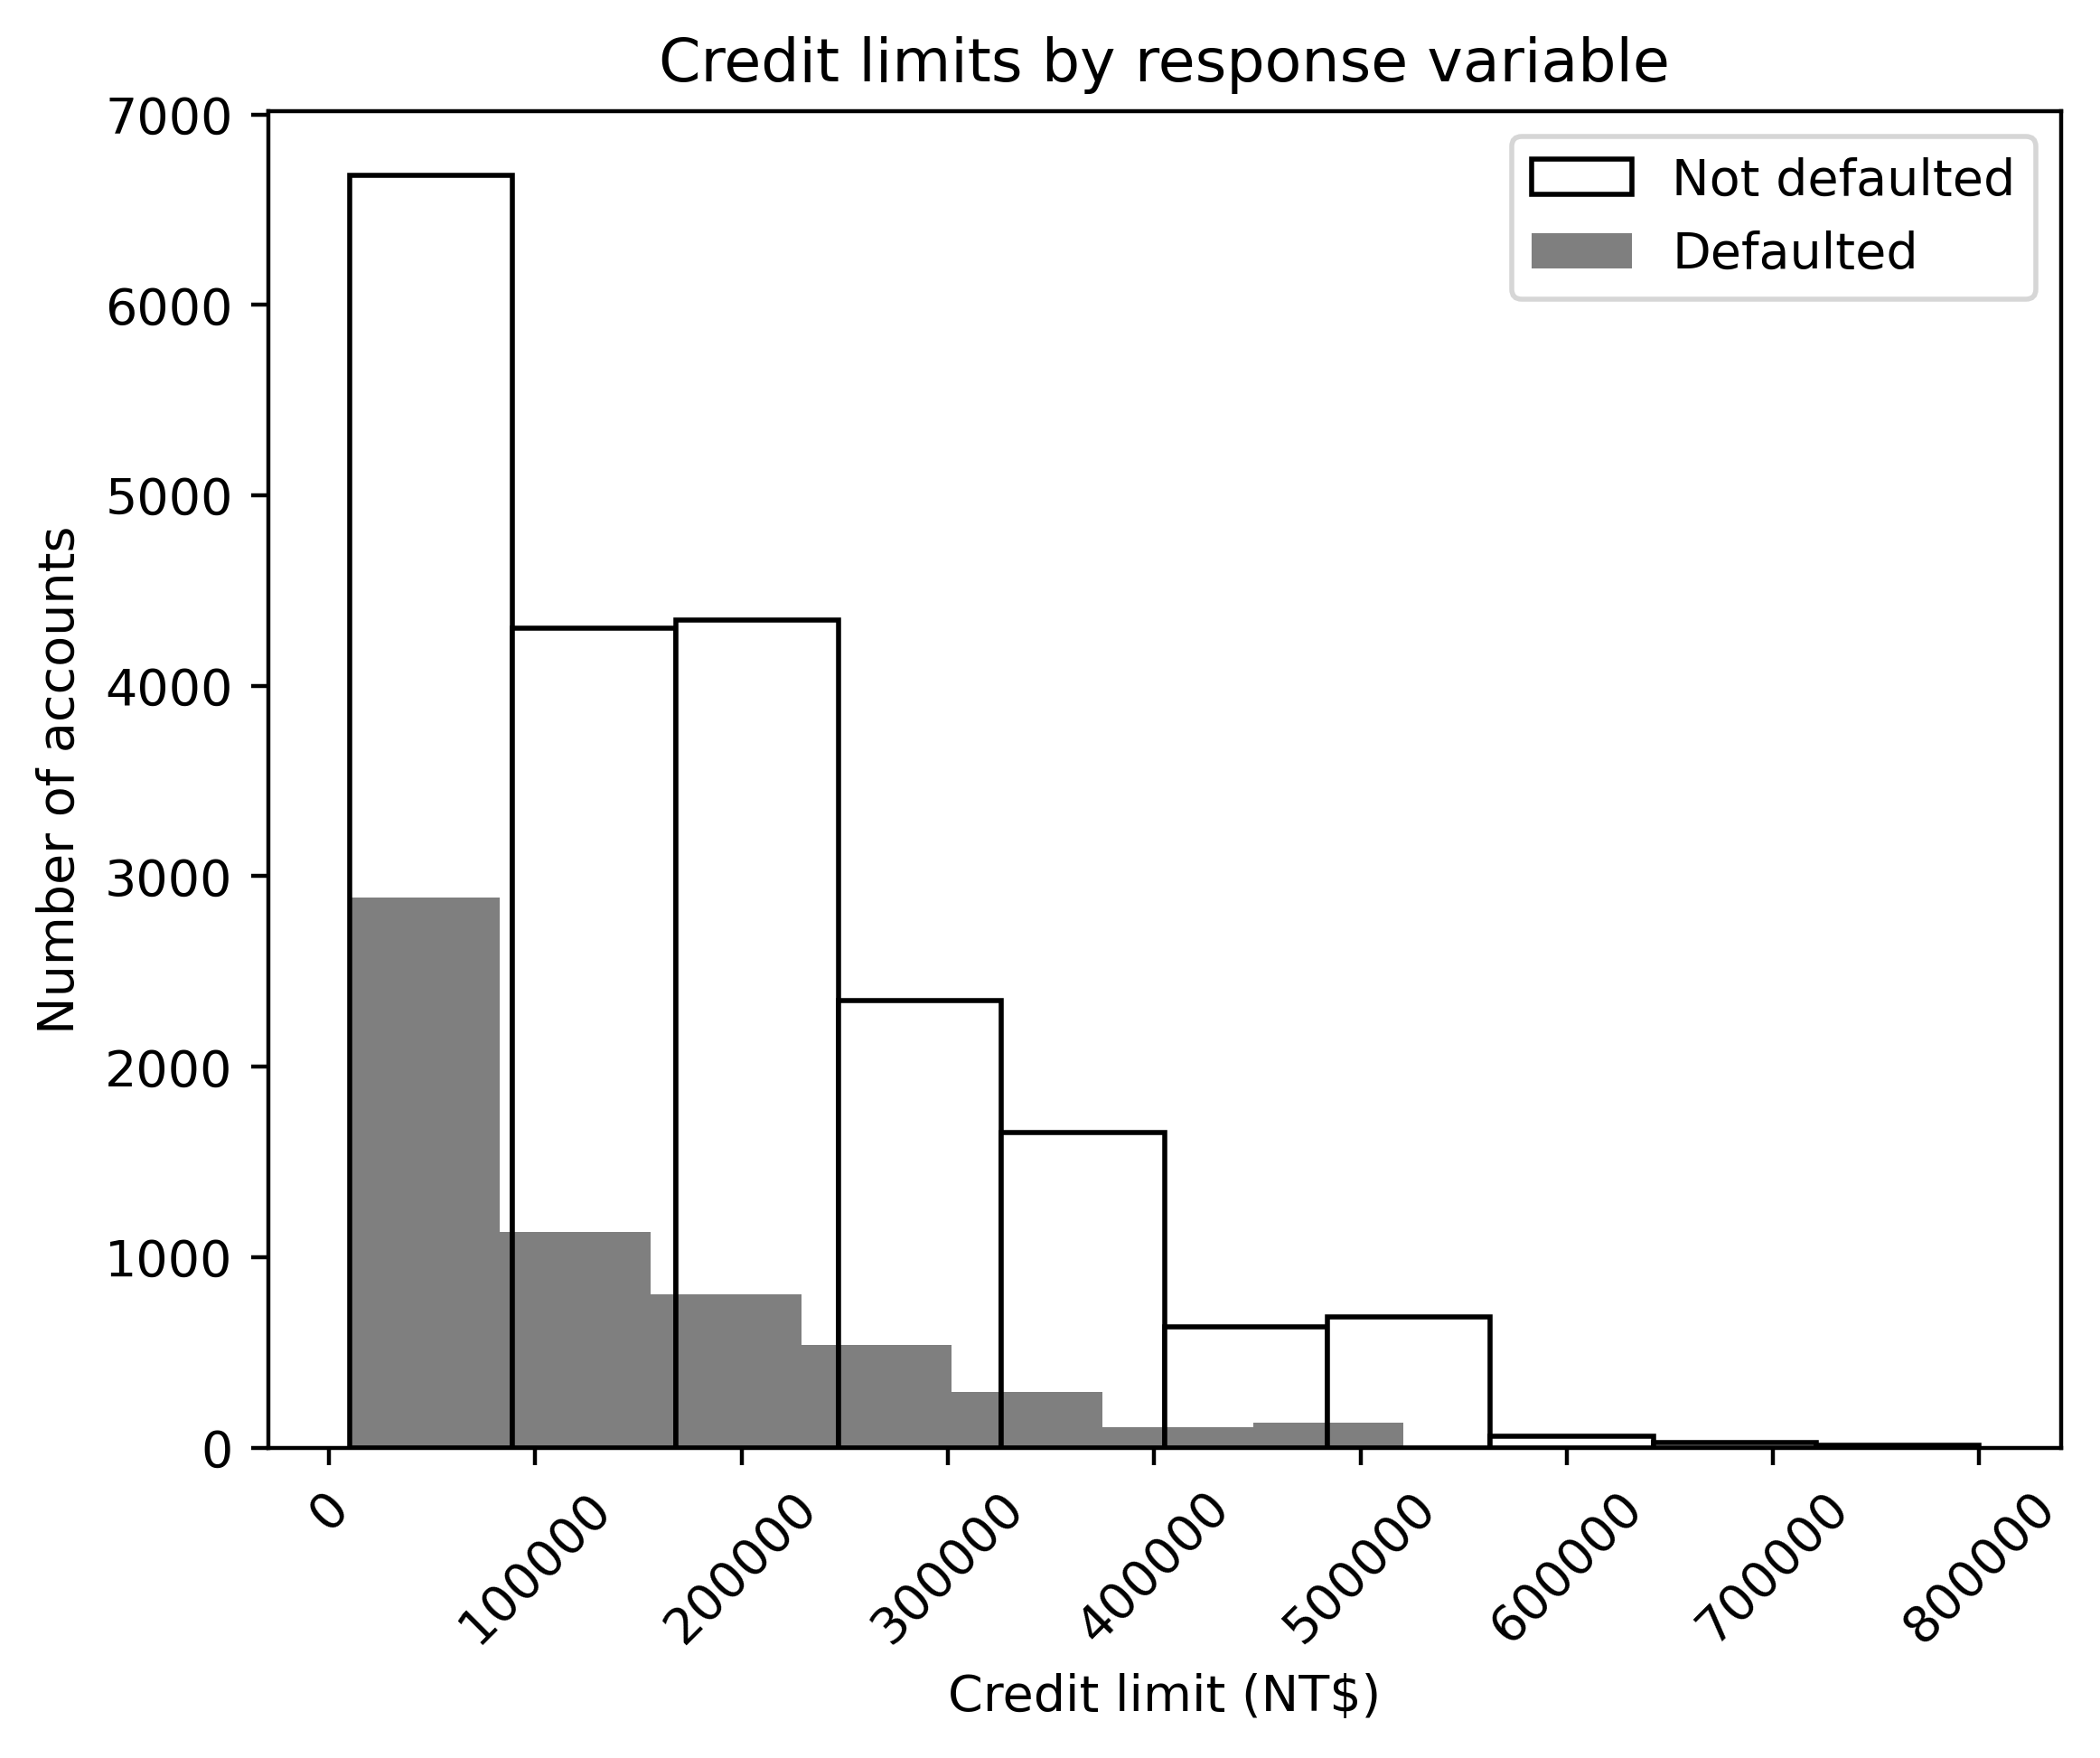

In [19]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'],edgecolor='black', color='white')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'],alpha=0.5, edgecolor=None, color='black')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

In [20]:
#Normalize Histogram for better interperatability
df['LIMIT_BAL'].max()

800000

In [21]:
bin_edges = list(range(0,850000,50000))
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


/tmp/ipykernel_19774/3785846387.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks*50000,2))


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

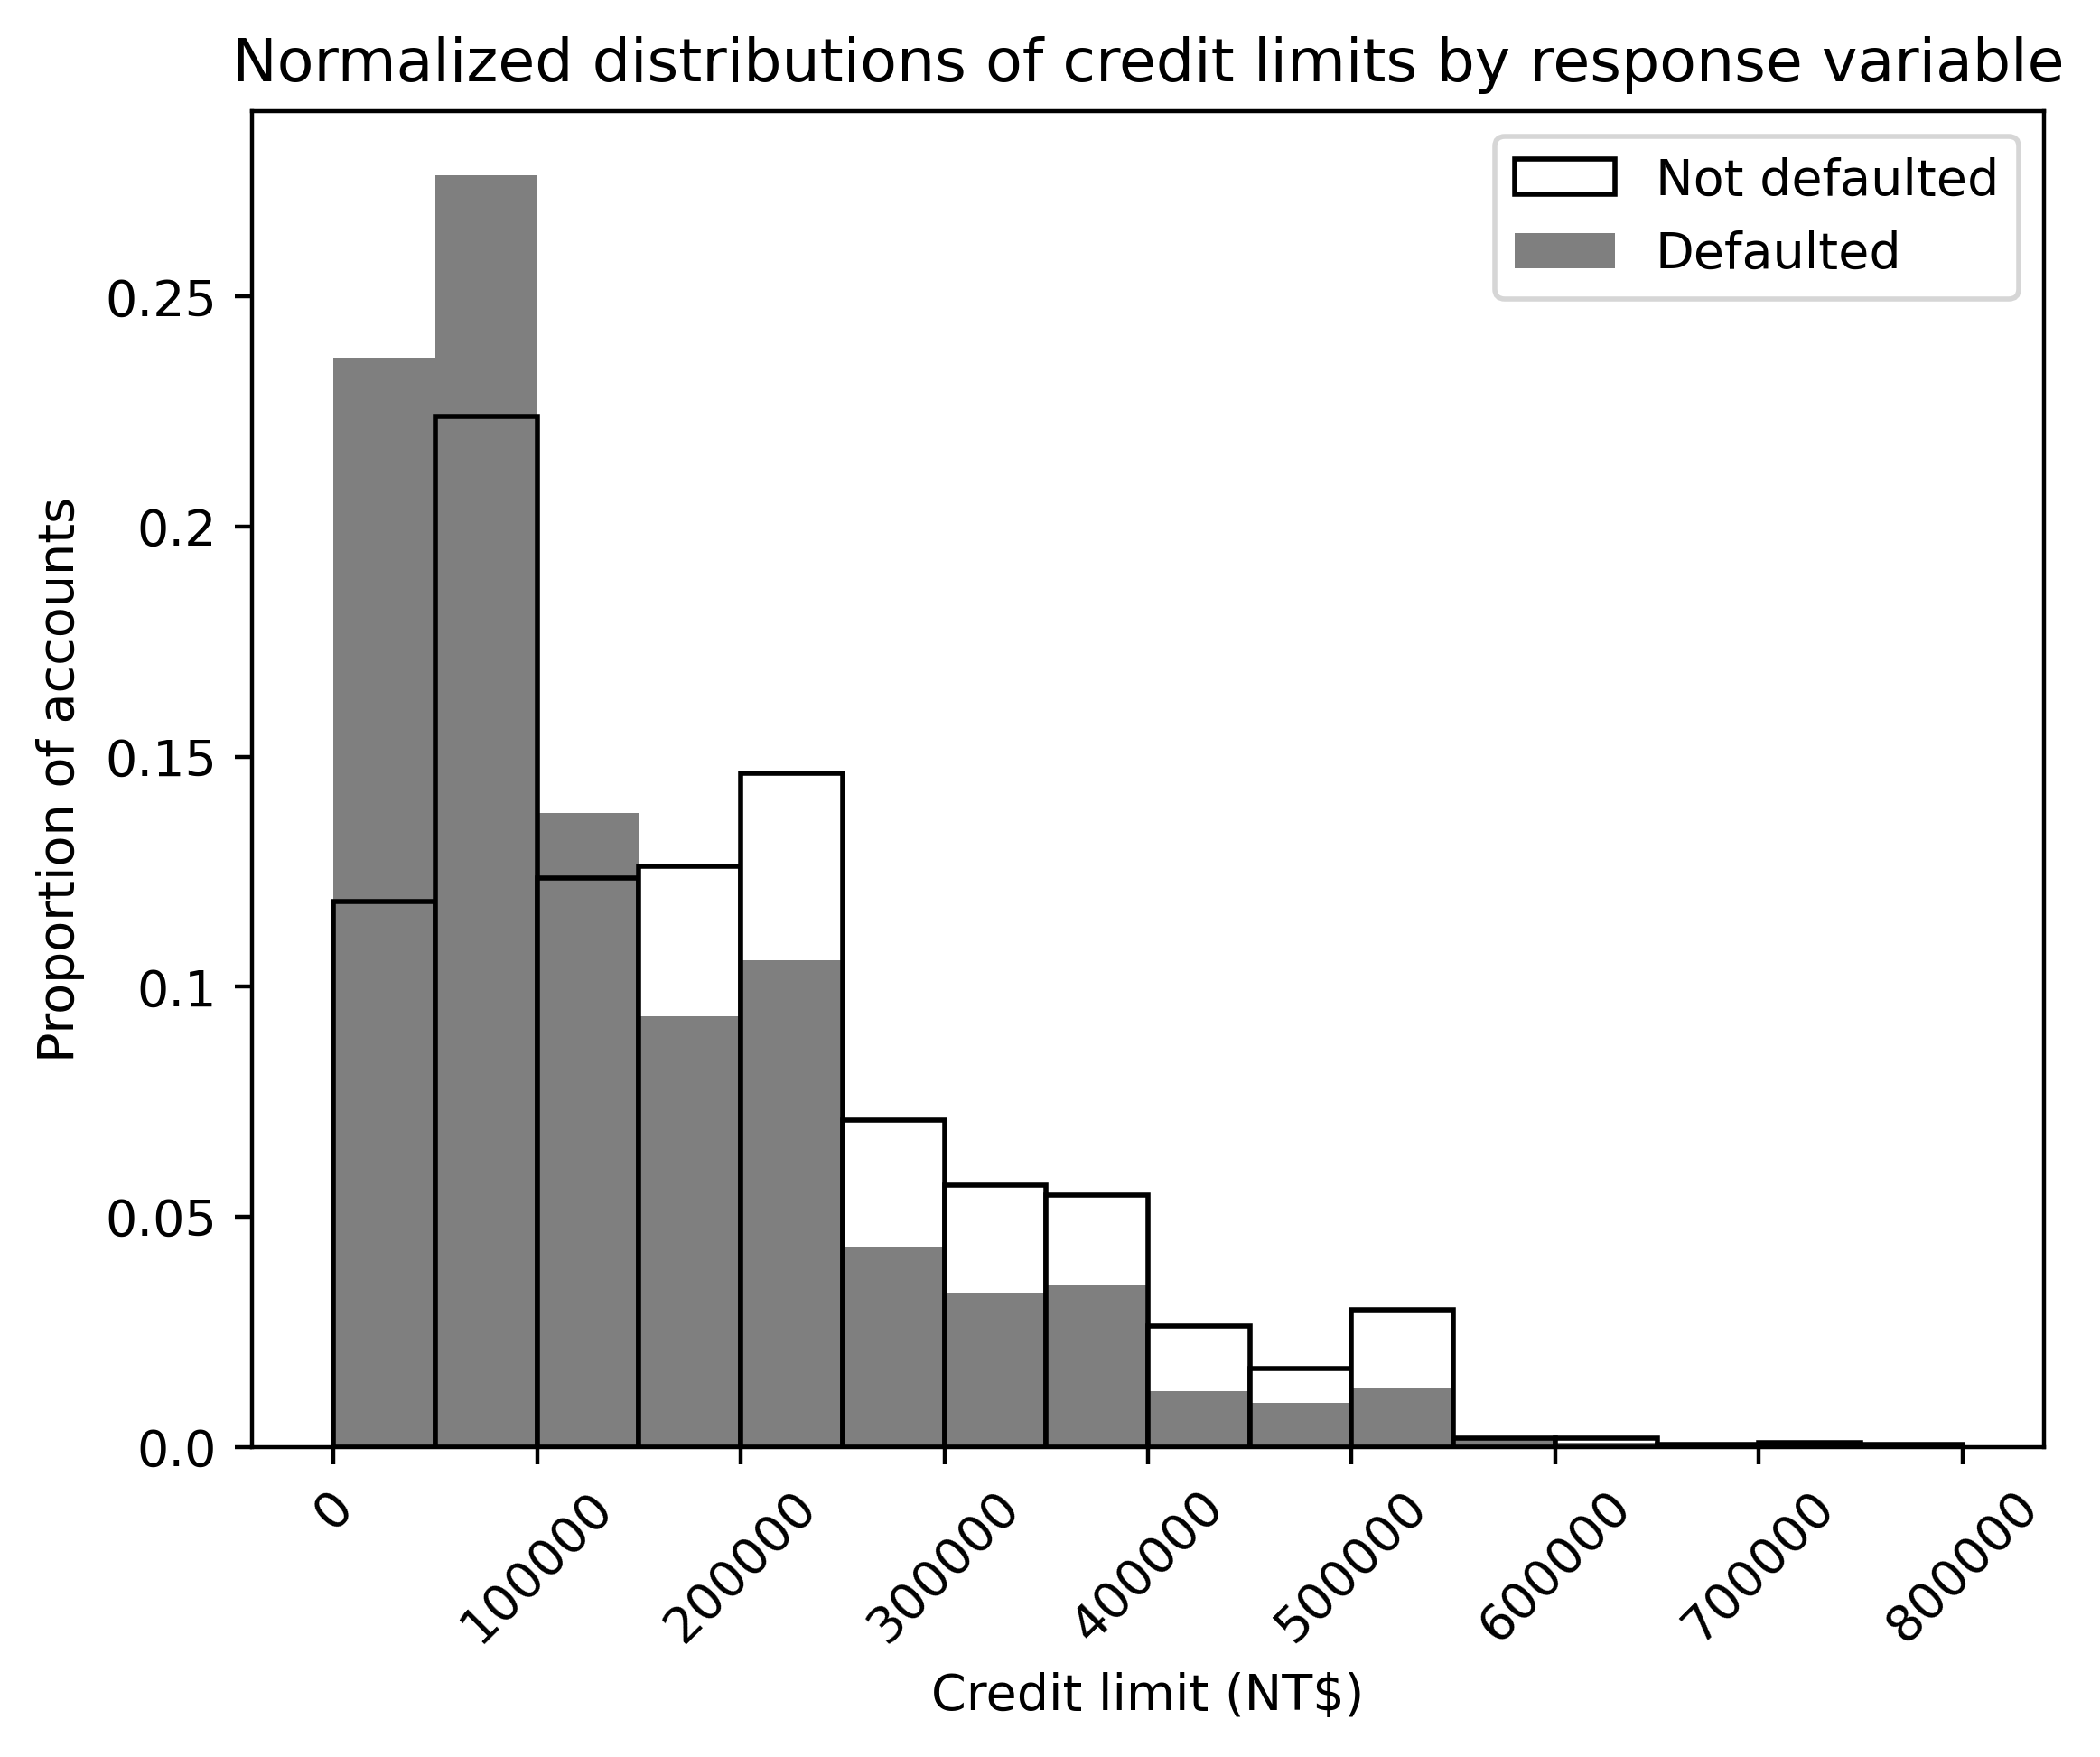

In [22]:
mpl.rcParams['figure.dpi'] = 400
axes = plt.axes()
axes.hist(
    df.loc[neg_mask, 'LIMIT_BAL'],
    bins=bin_edges, density=True,
    edgecolor='black', color='white')
axes.hist(
    df.loc[pos_mask, 'LIMIT_BAL'],
    bins=bin_edges, density=True, alpha=0.5,
    edgecolor=None, color='black')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

### Understanding Logistic Regression and the Sigmoid Function

Now, to open the "black box" of Logistic Regression completely by using functions in Python and the Sigmoid function.

In [23]:
#Vectorized Implemetation of np.exp

X_exp = np.linspace(-4,4,81)
print(X_exp[:5])
print(X_exp[-5:])

[-4.  -3.9 -3.8 -3.7 -3.6]
[3.6 3.7 3.8 3.9 4. ]


In [24]:
Y_exp = np.exp(X_exp)

Text(0.5, 1.0, 'Plot of $e^X$')

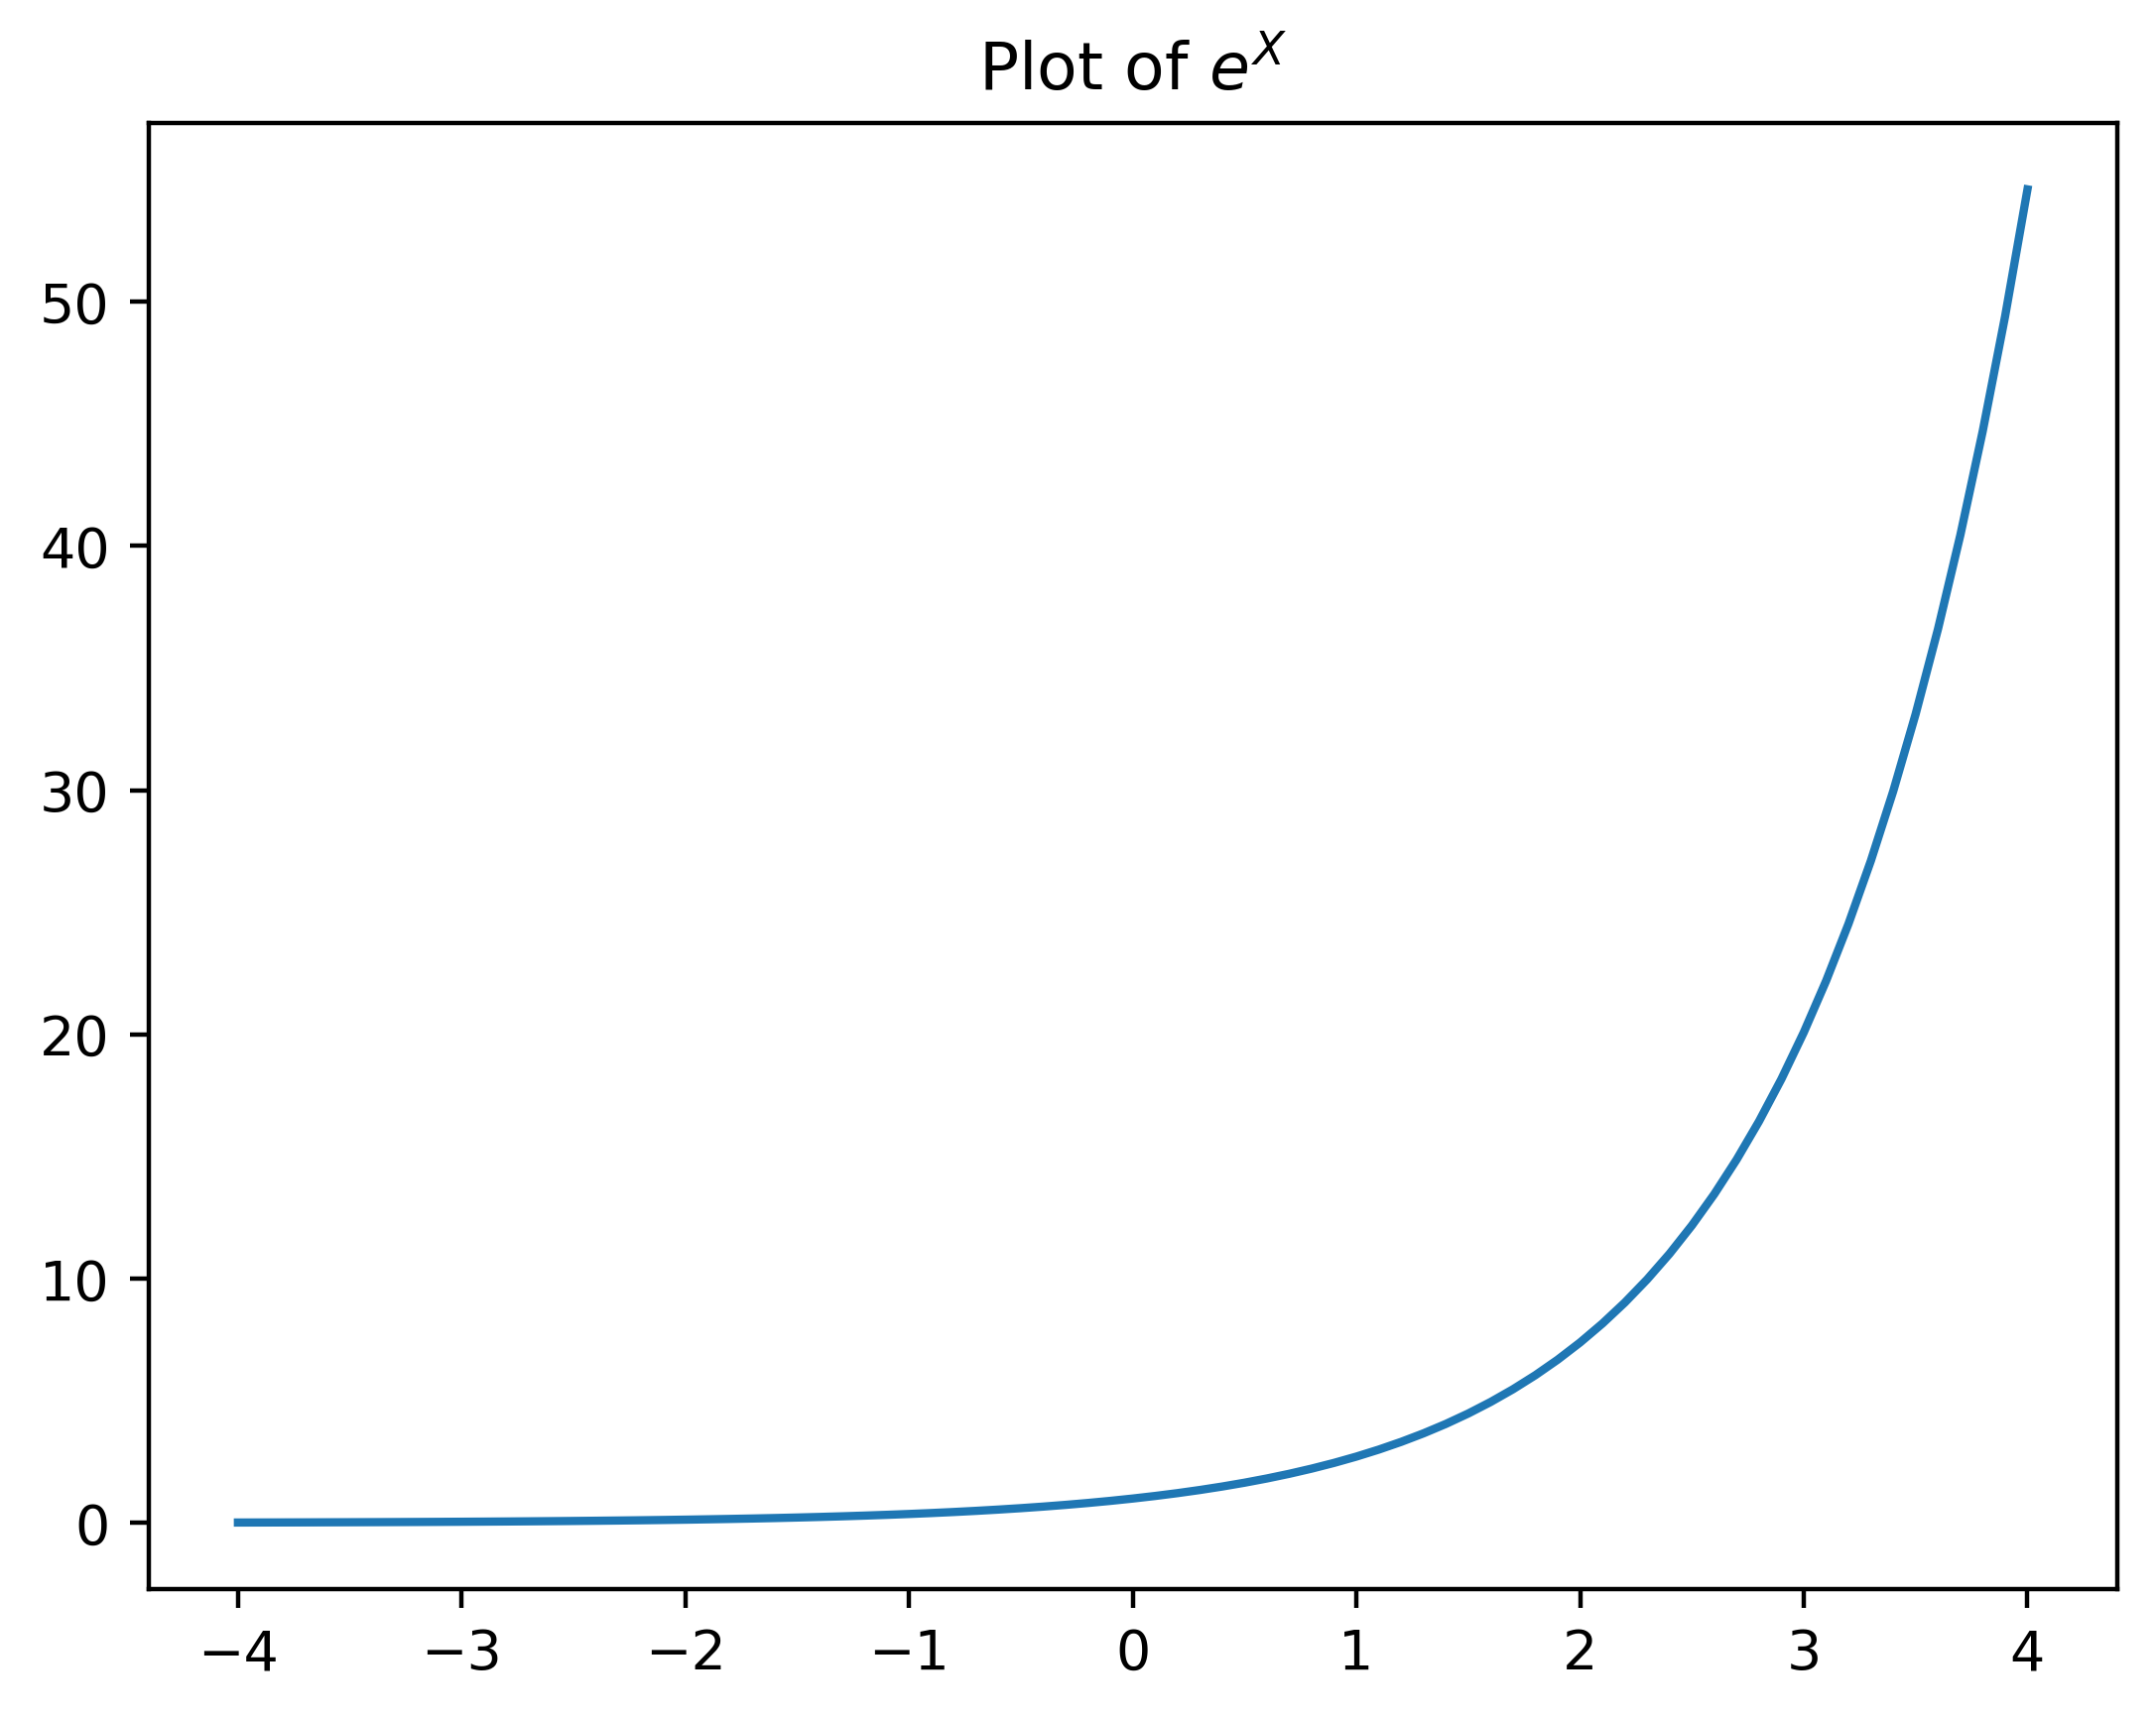

In [25]:
#Plot of e^x
plt.plot(X_exp, Y_exp)
plt.title('Plot of $e^X$')

In [26]:
#Define Sigmoid function
def sigmoid(X):
    Y = 1/(1 + np.exp(-X))
    return Y

Text(0.5, 1.0, 'The sigmoid function')

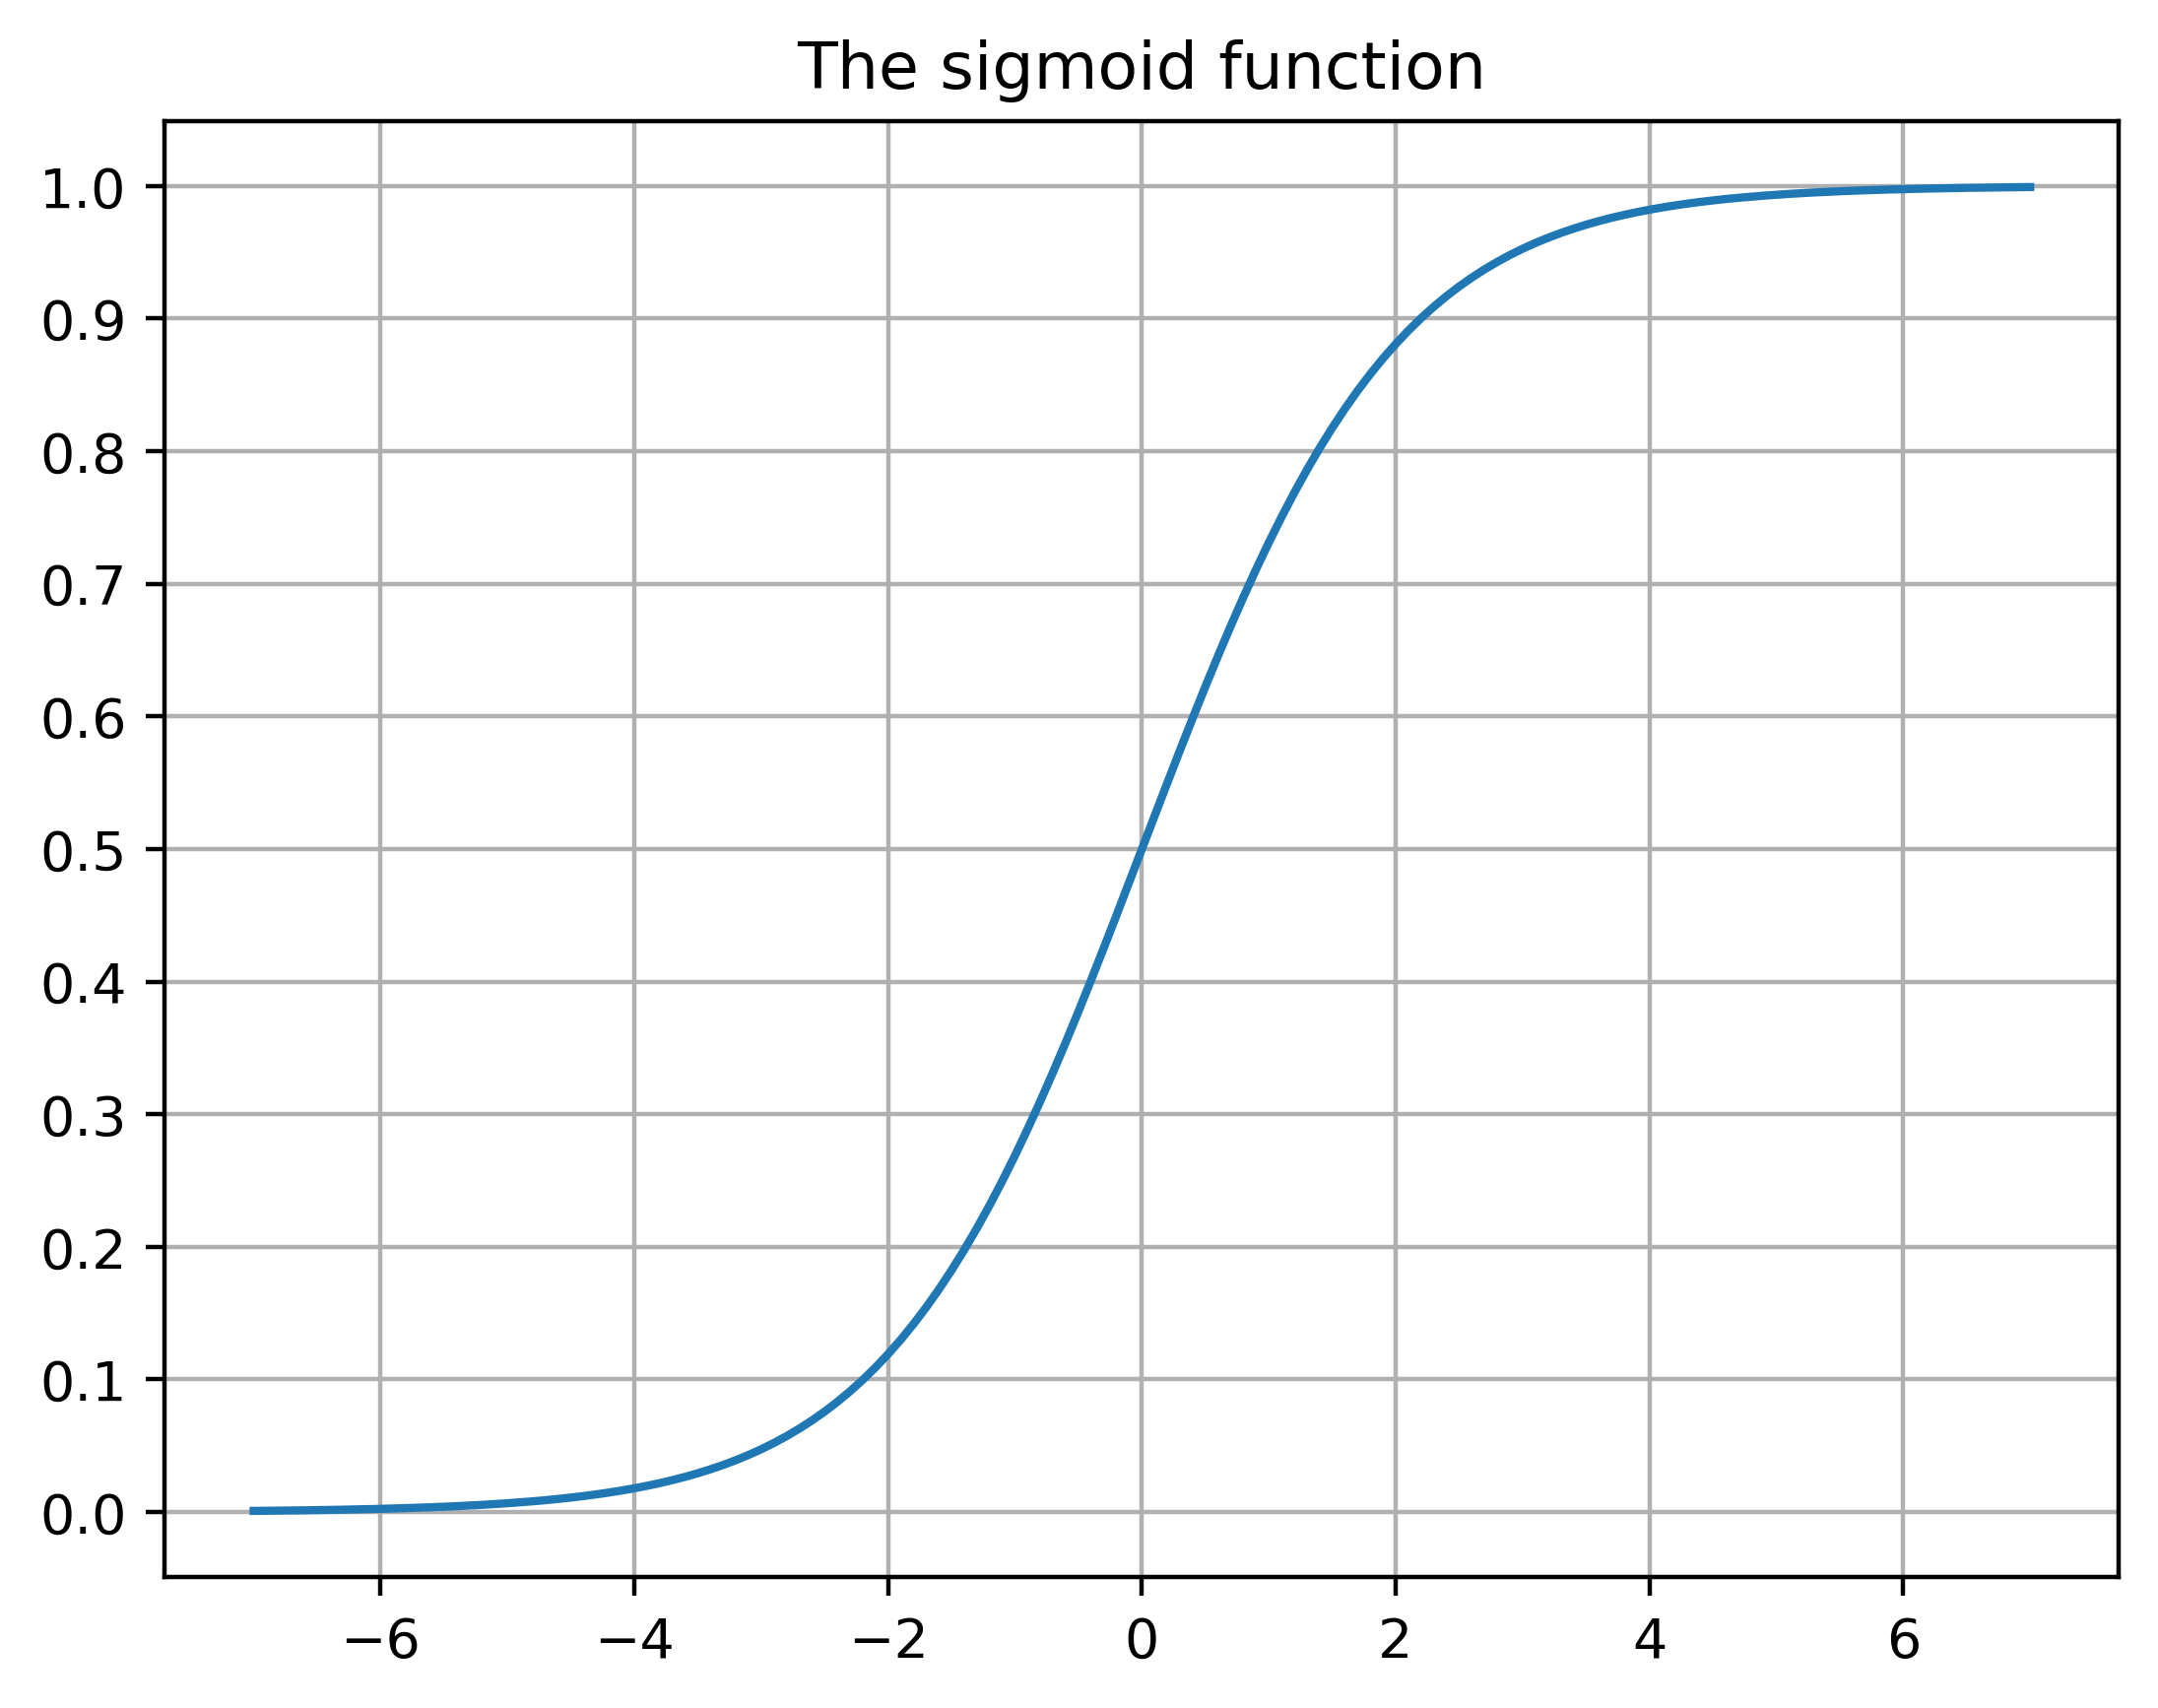

In [27]:
#Plot Sigmoid function
X_sig = np.linspace(-7,7,141)
Y_sig = sigmoid(X_sig)
plt.plot(X_sig,Y_sig)
plt.yticks(np.linspace(0,1,11))
plt.grid()
plt.title('The sigmoid function')

Now, to test the appropriateness of TEST_1, the strongest feature. We can do this by grouping samples of values of PAY_1, and by looking at the mean of the response variable. This allows us to effectively look at the probability *p* within each of these groups.

In [28]:
group_by_pay_mean_y #Grouping Samples of Pay_1 and looking at mean of response variable

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


In [29]:
p = group_by_pay_mean_y['default payment next month'].values #Extract mean values of response variable

In [30]:
q = 1-p #probability of not defaulting
print(q)
print(p)
print(q+p)

[0.86833603 0.82999802 0.87170475 0.66360012 0.30529857 0.2260274
 0.31746032 0.56521739 0.45454545 0.22222222 0.41176471]
[0.13166397 0.17000198 0.12829525 0.33639988 0.69470143 0.7739726
 0.68253968 0.43478261 0.54545455 0.77777778 0.58823529]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
#Odds ratio and log ods
odds_ratio = p/q
log_odds = np.log(odds_ratio)
log_odds

array([-1.88632574, -1.58561322, -1.91611649, -0.67937918,  0.82219194,
        1.23088026,  0.76546784, -0.26236426,  0.18232156,  1.25276297,
        0.35667494])

In [33]:
#To plot the log odds against feature values, we need to extract the feature values
group_by_pay_mean_y.index

Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='PAY_1')

Text(0, 0.5, 'Values of PAY_1')

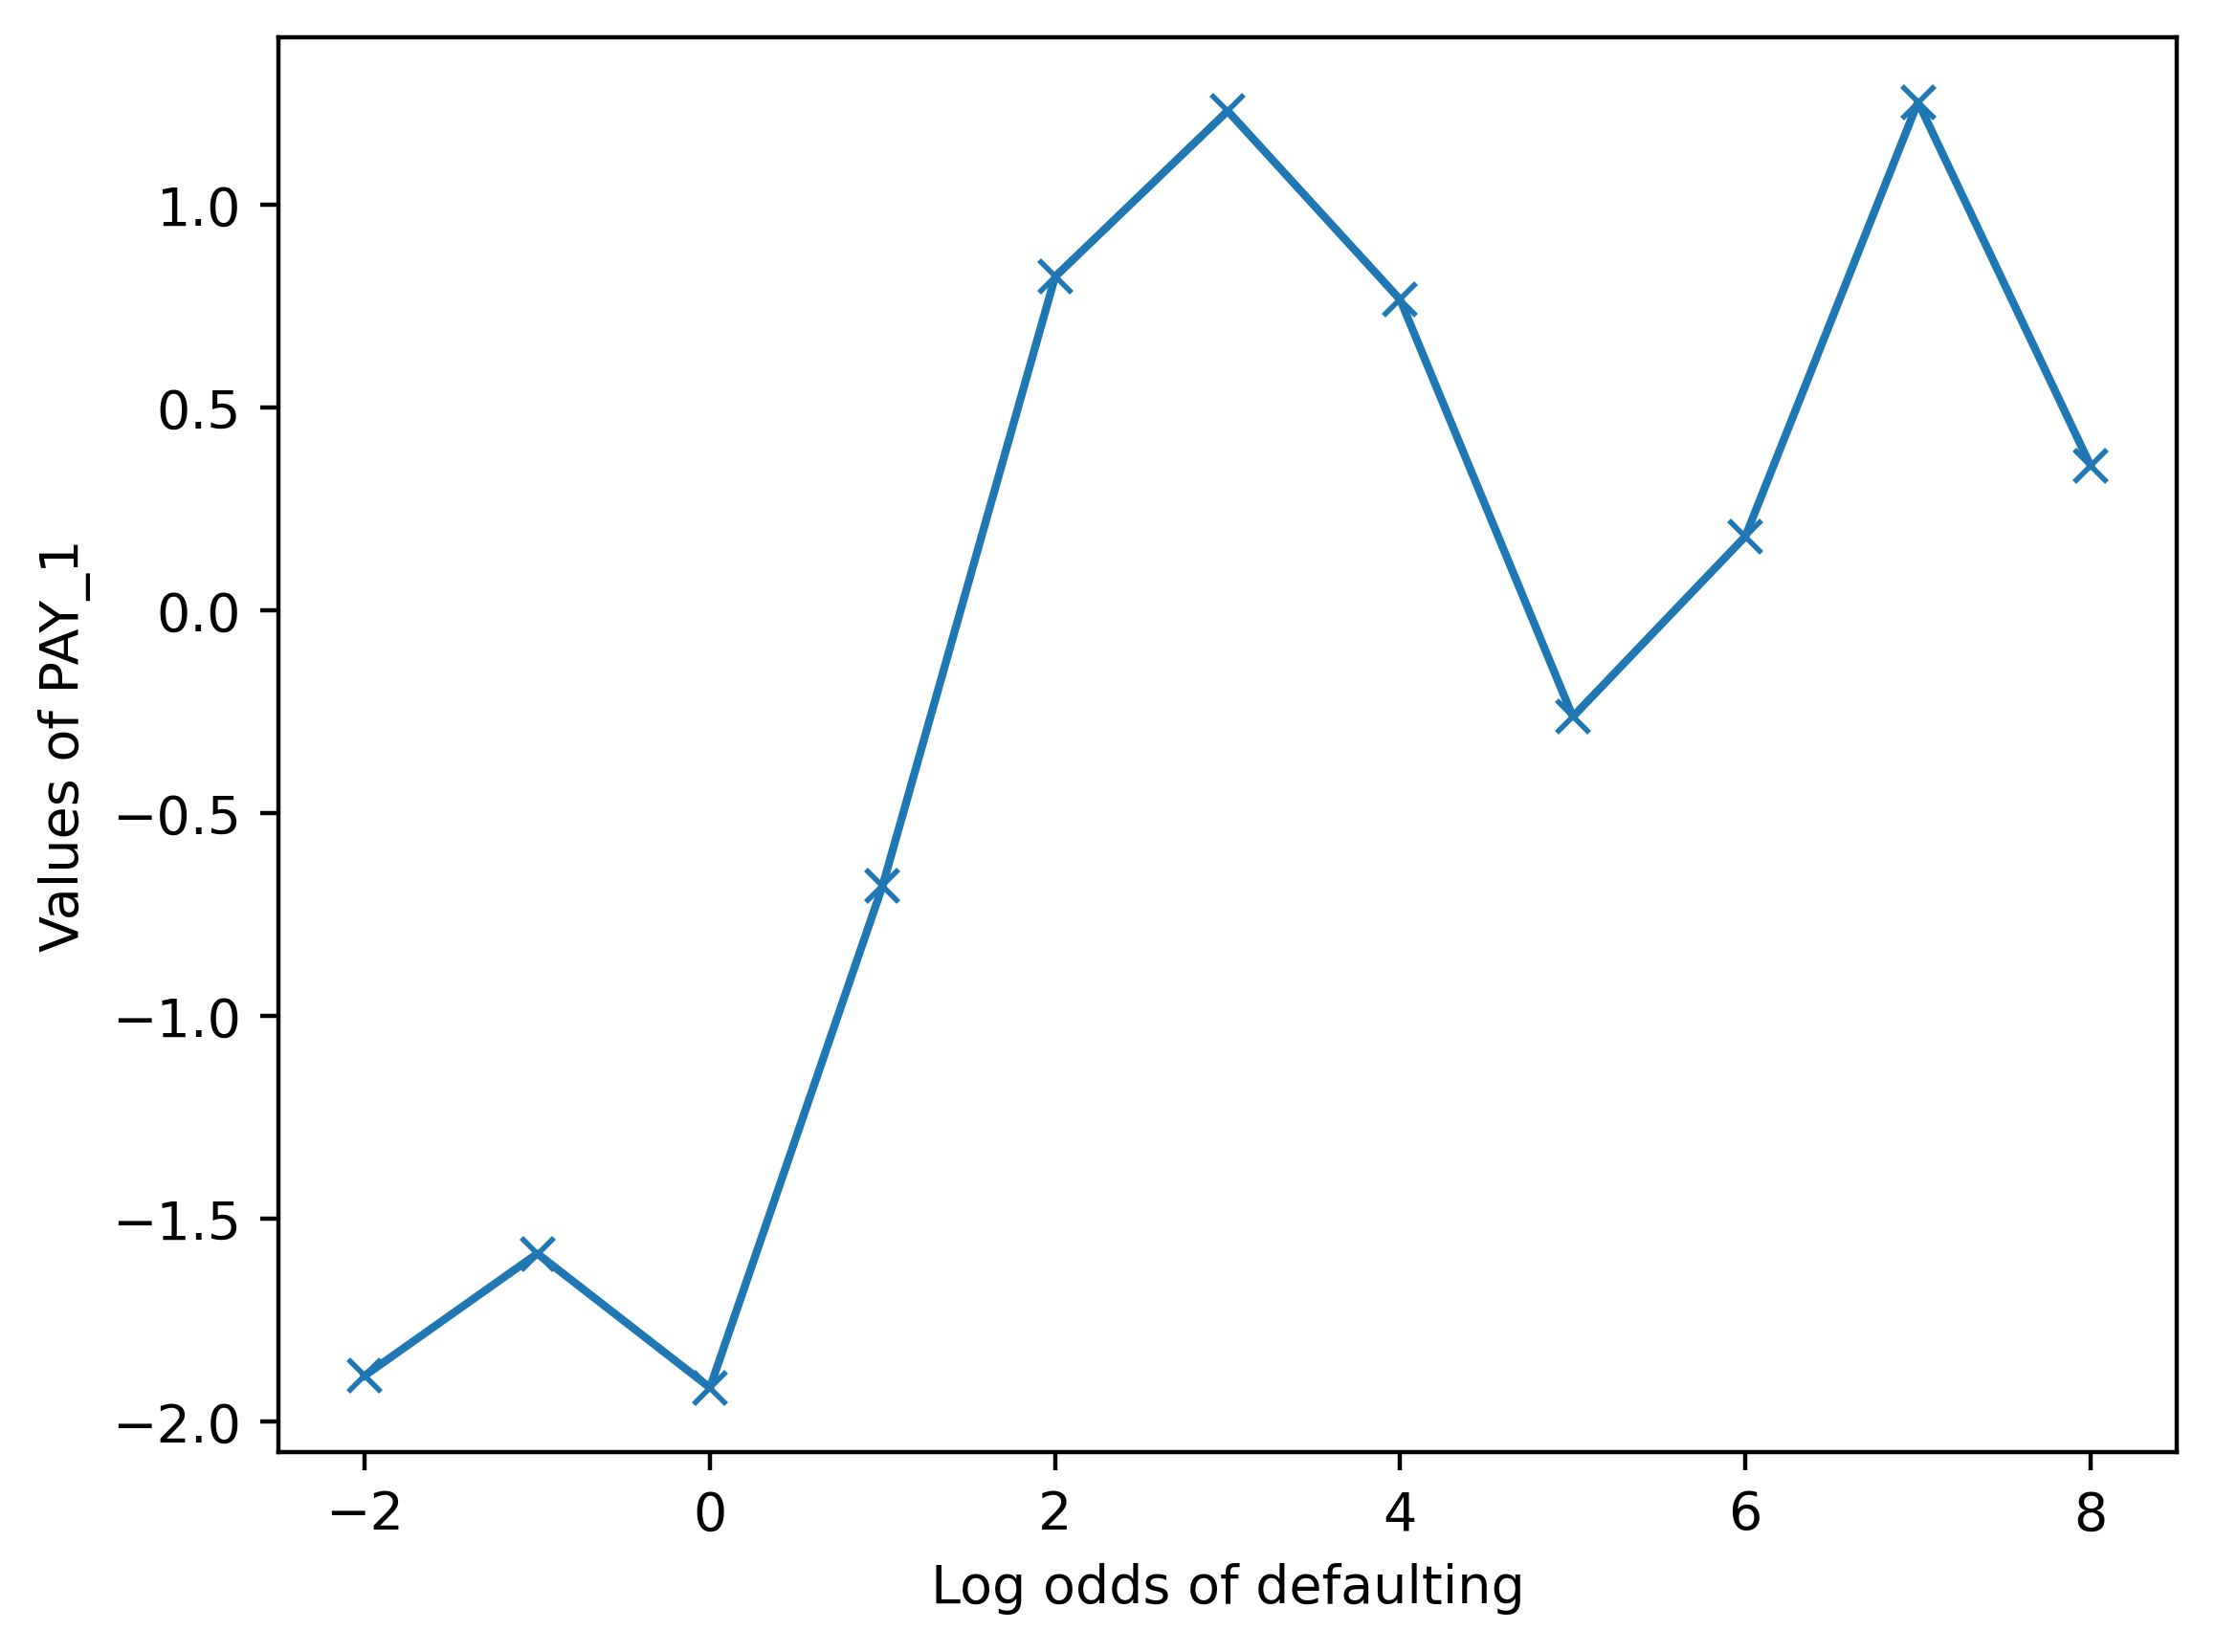

In [35]:
plt.plot(group_by_pay_mean_y.index,log_odds, '-x')
plt.xlabel('Log odds of defaulting')
plt.ylabel('Values of PAY_1')

### Linear Decision Boundary of Logistic Regression

This exercise involves using synthetic data to illustrate the concept of a decision boundary.

In [36]:
#Features of synthetic data
from numpy.random import default_rng
rg = default_rng(4)
X_1_pos = rg.uniform(low=1, high=7, size=(20,1))
print(X_1_pos[0:3])
X_1_neg = rg.uniform(low=3, high=10, size=(20,1))
print(X_1_neg[0:3])
X_2_pos = rg.uniform(low=1, high=7, size=(20,1))
print(X_2_pos[0:3])
X_2_neg = rg.uniform(low=3, high=10, size=(20,1))
print(X_2_neg[0:3])

[[6.65833663]
 [4.06796532]
 [6.85746223]]
[[7.93405322]
 [9.59962575]
 [7.65960192]]
[[5.15531227]
 [5.6237829 ]
 [2.14473103]]
[[6.49784918]
 [9.69185251]
 [9.32236912]]


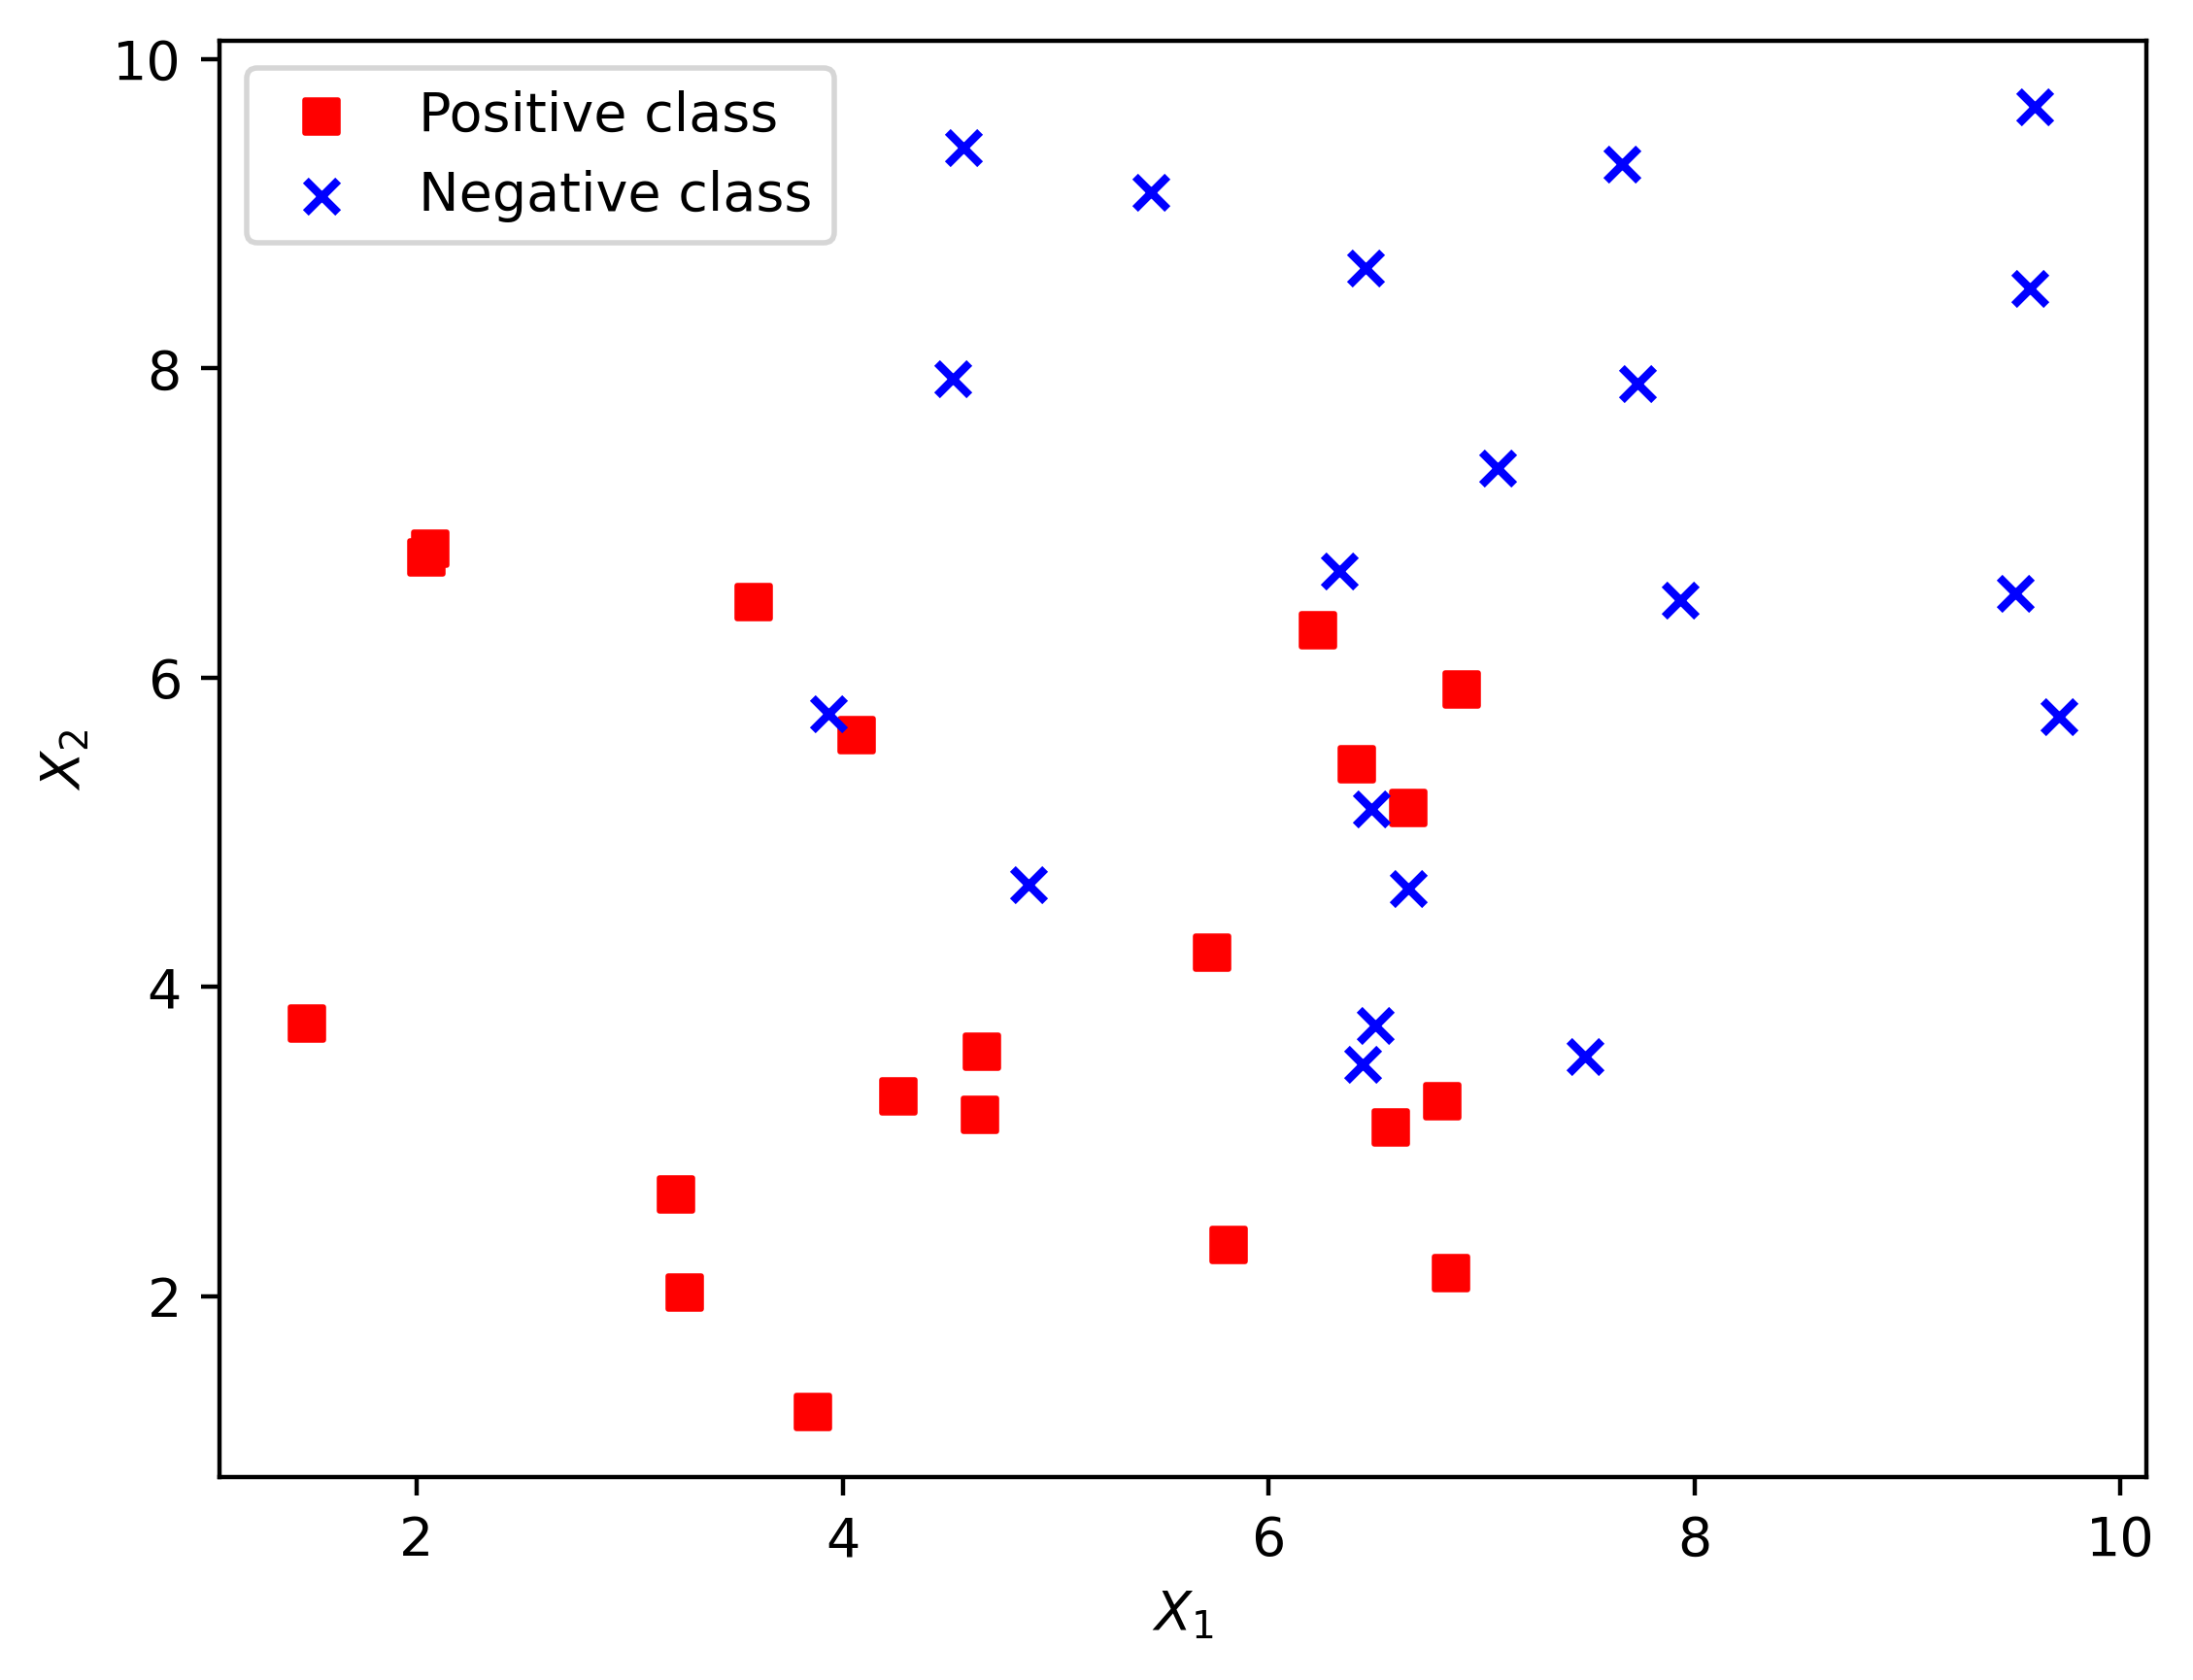

In [39]:
#Plot Synthetic Data
plt.scatter(X_1_pos, X_2_pos, color='red', marker='s')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class'])

In [40]:
#Assemble synthetic features into matrix so they can be used with scikit-learn
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]]) #40x2 matrix
print(X.shape)
print(X[0:3])

(40, 2)
[[6.65833663 5.15531227]
 [4.06796532 5.6237829 ]
 [6.85746223 2.14473103]]


In [42]:
y = np.vstack((np.ones((20,1)), np.zeros((20,1)))).reshape(40,) #vertical stack
print(y[0:5])
print(y[-5:])

[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


In [43]:
from sklearn.linear_model import LogisticRegression #import logistic regression
example_lr = LogisticRegression(solver='liblinear')
example_lr

LogisticRegression(solver='liblinear')

In [44]:
example_lr.fit(X,y) #train model

LogisticRegression(solver='liblinear')

In [45]:
#Get predictions and seperate them into indices of positive and negative class predictions
y_pred = example_lr.predict(X)
positive_indices = [counter for counter in range(len(y_pred))
                    if y_pred[counter]==1]
negative_indices = [counter for counter in range(len(y_pred))
                    if y_pred[counter]==0]
positive_indices

[2, 3, 4, 5, 6, 7, 9, 11, 13, 15, 16, 17, 18, 19, 26, 34, 36]

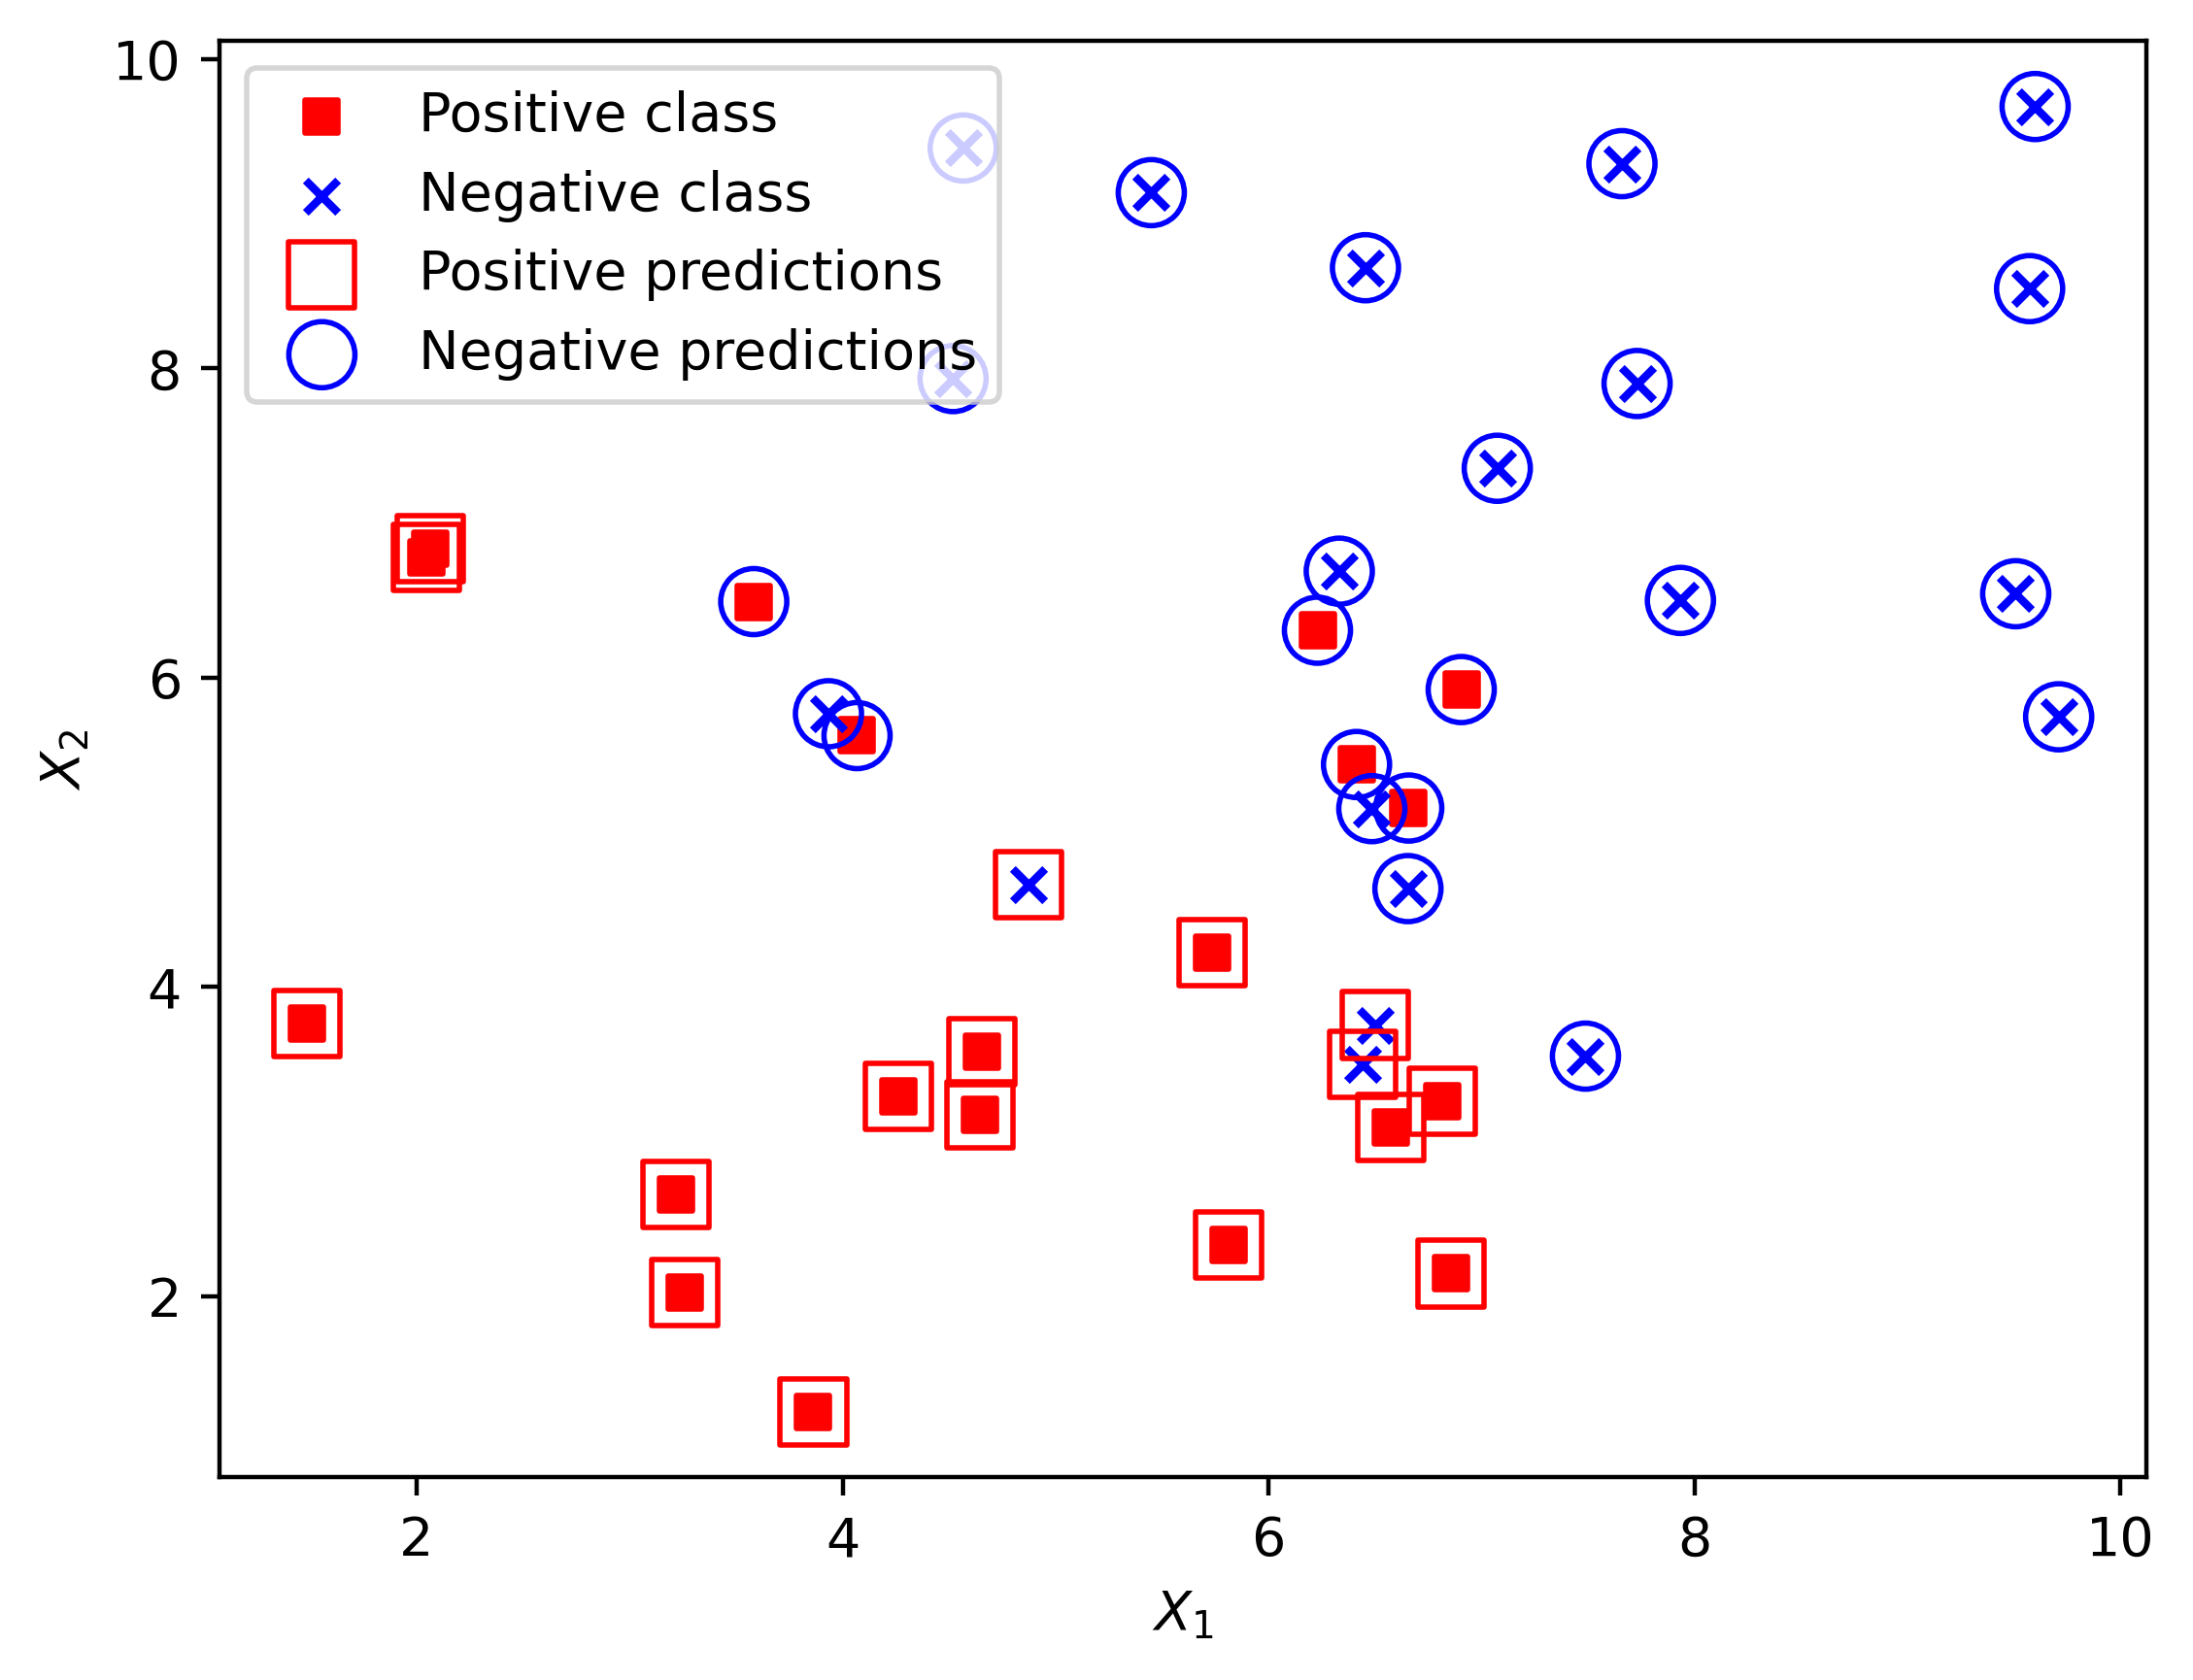

In [46]:
#Prediction is not fully correct, but let's plot it to see how close we got

plt.scatter(X_1_pos, X_2_pos, color='red', marker='s')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.scatter(X[positive_indices,0], X[positive_indices,1],
s=150, marker='s',
edgecolors='red', facecolors='none')
plt.scatter(X[negative_indices,0], X[negative_indices,1],
s=150, marker='o',
edgecolors='blue', facecolors='none')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class',\
'Positive predictions', 'Negative predictions'])

The classifier struggles with data points close to where the linear decision boundary might be. How to figure out and show the location of the actual decision boundary?

In [47]:
#Mathematics to obtain the decision boundary in 2-D space

theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print(theta_1, theta_2)

-0.16472042583006558 -0.25675185949979507


In [48]:
theta_0 = example_lr.intercept_

In [50]:
X_1_decision_boundary = np.array([0, 10])
X_2_decision_boundary = -(theta_1/theta_2)*X_1_decision_boundary- (theta_0/theta_2)

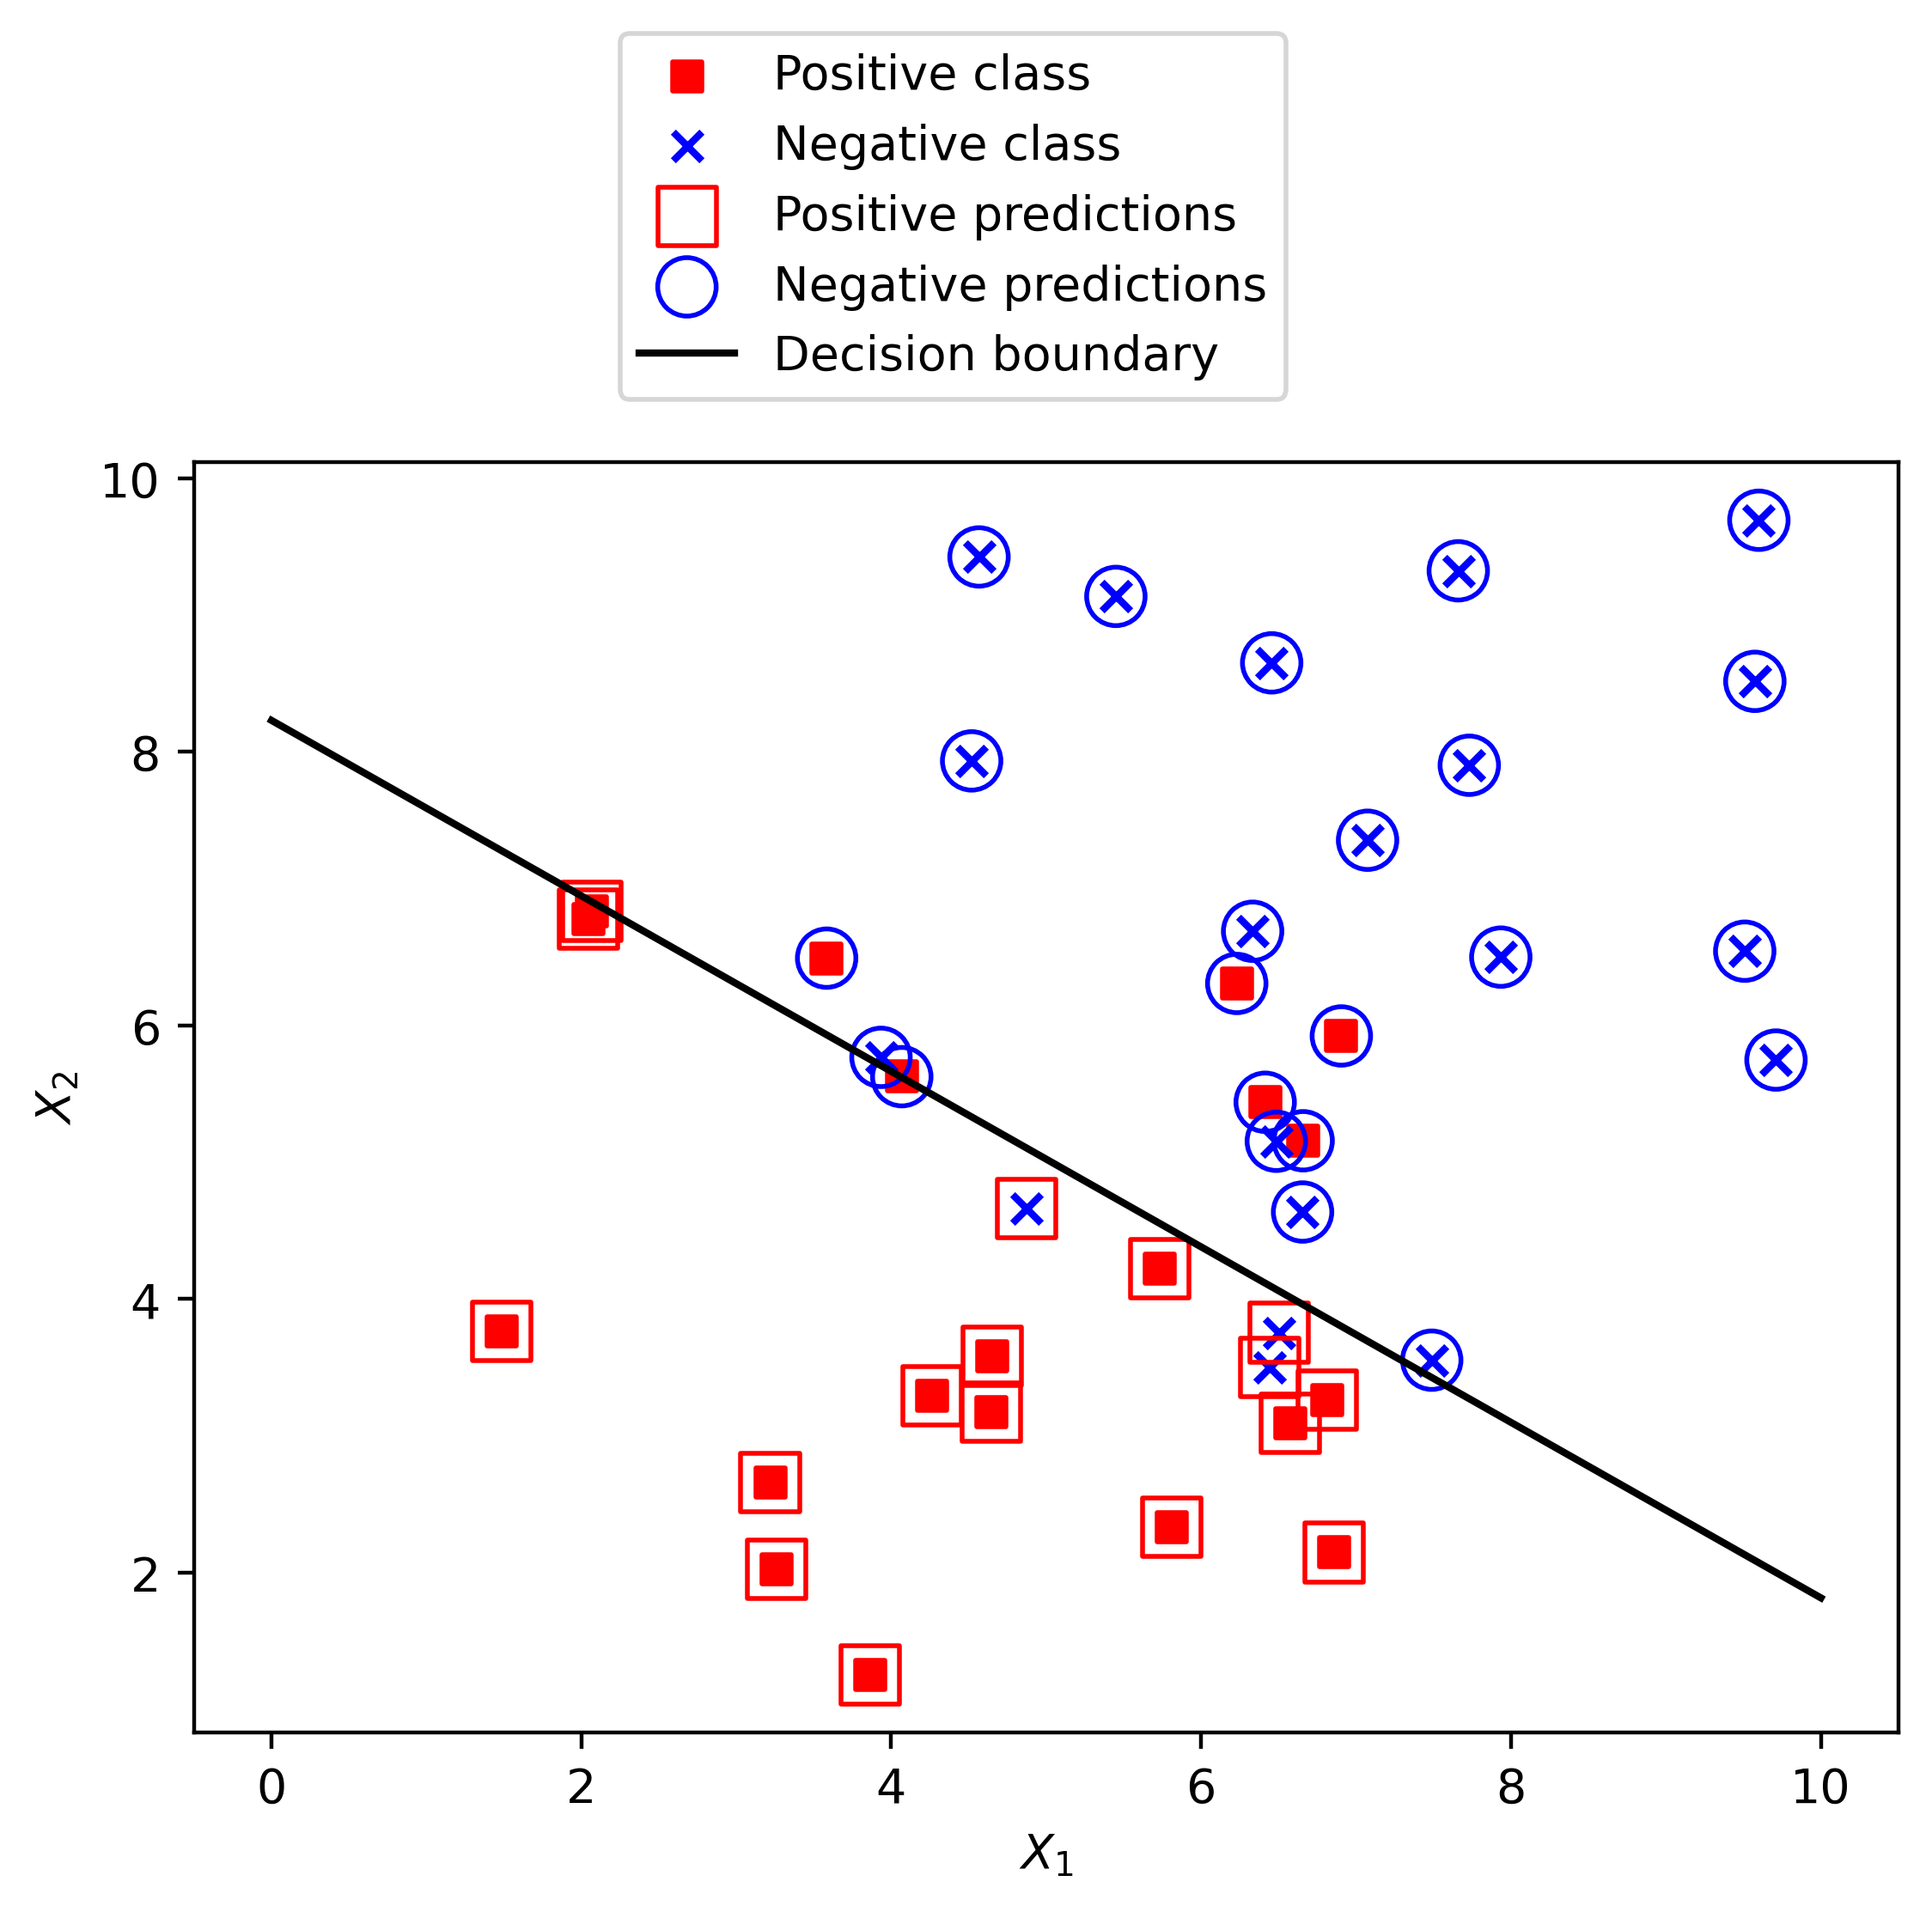

In [51]:
#Plot decision boundary
pos_true = plt.scatter(X_1_pos, X_2_pos,
color='red', marker='s',
label='Positive class')
neg_true = plt.scatter(X_1_neg, X_2_neg,
                       color='blue', marker='x',
                       label='Negative class')
pos_pred = plt.scatter(X[positive_indices,0],
                       X[positive_indices,1],
                       s=150, marker='s',
                       edgecolors='red', facecolors='none',
                       label='Positive predictions')
neg_pred = plt.scatter(X[negative_indices,0],
                       X[negative_indices,1],
                       s=150, marker='o',
                       edgecolors='blue', facecolors='none',
                       label='Negative predictions')
dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary,'k-', label='Decision boundary')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc=[0.25, 1.05])

### Fitting a Logistic Regression Model and Directly Using the Coefficients

In [54]:
#test-train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['PAY_1', 'LIMIT_BAL']].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24)

In [55]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='liblinear')
lr_model

LogisticRegression(solver='liblinear')

In [56]:
#train the data
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [57]:
#predict the data
y_pred = lr_model.predict(X_test)

In [58]:
#Manually calculate predicted probabilities

y_pred = lr_model.predict(X_test)
print(lr_model.coef_, lr_model.intercept_)

[[ 8.27451187e-11 -6.80876727e-06]] [-6.57647457e-11]


In [59]:
np.ones((X_test.shape[0],1)).shape

(5333, 1)

In [60]:
ones_and_features = np.hstack(
    [np.ones((X_test.shape[0],1)), X_test])
ones_and_features



array([[ 1.0e+00,  2.0e+00,  1.6e+05],
       [ 1.0e+00,  1.0e+00,  5.0e+04],
       [ 1.0e+00, -1.0e+00,  2.0e+05],
       ...,
       [ 1.0e+00, -1.0e+00,  5.0e+04],
       [ 1.0e+00,  1.0e+00,  2.3e+05],
       [ 1.0e+00,  2.0e+00,  1.0e+05]])

In [61]:
intercept_and_coefs = np.concatenate(
    [lr_model.intercept_.reshape(1,1),
     lr_model.coef_], axis=1)
intercept_and_coefs

array([[-6.57647457e-11,  8.27451187e-11, -6.80876727e-06]])

In [62]:
X_lin_comb = np.dot(intercept_and_coefs,
                    np.transpose(ones_and_features))

In [63]:
y_pred_proba_manual = sigmoid(X_lin_comb)
y_pred_manual = y_pred_proba_manual >= 0.5
y_pred.shape

(5333,)

In [64]:
y_pred_manual.shape

(1, 5333)

In [65]:
np.array_equal(y_pred.reshape(1,-1), y_pred_manual)

True

In [66]:
#ROC AUC Score
from sklearn.metrics import roc_auc_score

y_test.shape

(5333,)

In [68]:
y_pred_proba_manual.shape

(1, 5333)

In [69]:
roc_auc_score(y_test, y_pred_proba_manual.reshape(y_pred_proba_manual.shape[1],))

0.627207450280691